## Importing the Necessary Libraries for data preprocessing, modeling and visualization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.subplots as sp
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler

## Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading the merged pollution data.

In [ ]:
PollutionData = pd.read_csv("/content/drive/MyDrive/IDMP_project/Air Pollution Raw Data/PollutionDataMerged.csv")
PollutionData.head()

Unnamed: 0.1  Unnamed: 0        Date  Year  Month  Day  \
0             0      433669  2016-01-01  2016      1    1   
1             1      433670  2016-01-02  2016      1    2   
2             2      433671  2016-01-03  2016      1    3   
3             3      433672  2016-01-04  2016      1    4   
4             4      433673  2016-01-05  2016      1    5   

                                 Address    State     County        City  ...  \
0  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama  Jefferson  Birmingham  ...   
1  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama  Jefferson  Birmingham  ...   
2  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama  Jefferson  Birmingham  ...   
3  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama  Jefferson  Birmingham  ...   
4  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama  Jefferson  Birmingham  ...   

   CO 1st Max Hour  CO AQI  SO2 Mean  SO2 1st Max Value  SO2 1st Max Hour  \
0                7     1.0  0.413636                1.2                 3   
1               23     6.0  0.663636                1.4                 3   
2                1     7.0  0.863636                1.9                 3   
3                0     2.0  0.510000                2.1                 3   
4                6    20.0  0.750000                2.7                 3   

   SO2 AQI   NO2 Mean  NO2 1st Max Value  NO2 1st Max Hour  NO2 AQI  
0      1.0   2.520833                4.1                11        4  
1      1.0   8.437500               27.5                18       25  
2      1.0  12.750000               20.7                 8       19  
3      3.0   3.141667                6.1                 2        6  
4      3.0   9.316667               28.5                19       26  

[5 rows x 26 columns]

Performing Data Preprocessing for finding the confidence interval of the Pollutants

In [ ]:
CaliforniaData = PollutionData[(PollutionData["State"]== "California") & (PollutionData["Year"] >= 2016)].copy()
CaliforniaData["Date"] = pd.to_datetime(CaliforniaData["Date"])
CaliforniaData["DayofTheYear"] = CaliforniaData["Date"].apply(lambda x: x.dayofyear)

## Function for calculating the confidence bands

In [ ]:
def GroupDataByPollutant(Pollutant,Dataset):
  CaliforniaDataGrouped = Dataset[['DayofTheYear',Pollutant]].groupby('DayofTheYear').aggregate(['mean','std'])
  CaliforniaDataGrouped['upper'] = CaliforniaDataGrouped[Pollutant,'mean'] + 2*CaliforniaDataGrouped[Pollutant,'std']
  CaliforniaDataGrouped['lower'] = CaliforniaDataGrouped[Pollutant,'mean'] - 2*CaliforniaDataGrouped[Pollutant,'std']
  return CaliforniaDataGrouped



## Iteratively Group the pollutants for plotting

In [ ]:
ListOfGroupedPollutants = []
Pollutants = ['NO2 AQI','SO2 AQI','CO AQI','O3 AQI']
for pollutant in Pollutants:
  PollutantGrouped = GroupDataByPollutant(pollutant,CaliforniaData)
  ListOfGroupedPollutants.append(PollutantGrouped)

## Visualizing the confidence intervals

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
Color = ['Red','Green','Blue','Yellow']
UpperColor = ['Purple','Pink','indianred','Blue']

# Create a 2x2 subplot
fig = make_subplots(rows=2, cols=2, subplot_titles=("NO2 AQI", "SO2 AQI", "CO AQI", "O3 AQI"))

for i in range(4):
    Pollutant = Pollutants[i]
    Index = ListOfGroupedPollutants[i].index
    MeanValues = ListOfGroupedPollutants[i][Pollutant, 'mean']
    UpperValue = ListOfGroupedPollutants[i]['upper']
    LowerValue = ListOfGroupedPollutants[i]['lower']

    mean_trace = go.Scatter(x=Index,
                            y=MeanValues,
                            mode='lines',
                            name='Mean ' + Pollutant,
                            line=dict(color=Color[i], width=2)
                            )
    upper_trace = go.Scatter(x=Index,
                             y=UpperValue,
                             mode='lines',
                             line=dict(color=UpperColor[i], dash='dash', width=1),
                             name='Upper Bound')
    lower_trace = go.Scatter(x=Index,
                             y=LowerValue,
                             mode='lines',
                             line=dict(color=UpperColor[i], dash='dash', width=1),
                             name='Lower Bound')

    # Add traces to the subplot
    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(mean_trace, row=row, col=col)
    fig.add_trace(upper_trace, row=row, col=col)
    fig.add_trace(lower_trace, row=row, col=col)

    # Update x and y axes
    fig.update_xaxes(title_text="Day of the Year", row=row, col=col, gridcolor='lightgray')
    fig.update_yaxes(title_text='Mean ' + Pollutant, row=row, col=col, gridcolor='lightgray')

# Update layout and legend
fig.update_layout(title="Mean Pollutants in California",
                  plot_bgcolor='white',
                  font=dict(family='Arial', size=12, color='black'))

fig.update_traces(showlegend=True, selector=dict(type='scatter'), marker=dict(color='royalblue'))
fig.update_traces(showlegend=True, selector=dict(name="Upper Bound"), line=dict(color='indianred'))
fig.update_traces(showlegend=True, selector=dict(name="Lower Bound"), line=dict(color='indianred'))

fig.show()


In [ ]:
CaliforniaDataGroupedByDate = CaliforniaData.groupby(['Date']).mean()
CaliforniaDataGroupedByDate.index = pd.to_datetime(CaliforniaDataGroupedByDate.index)

<ipython-input-90-1e57adccfe32>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## Obtaining a seasonal decompose of the data for a 365 day period.

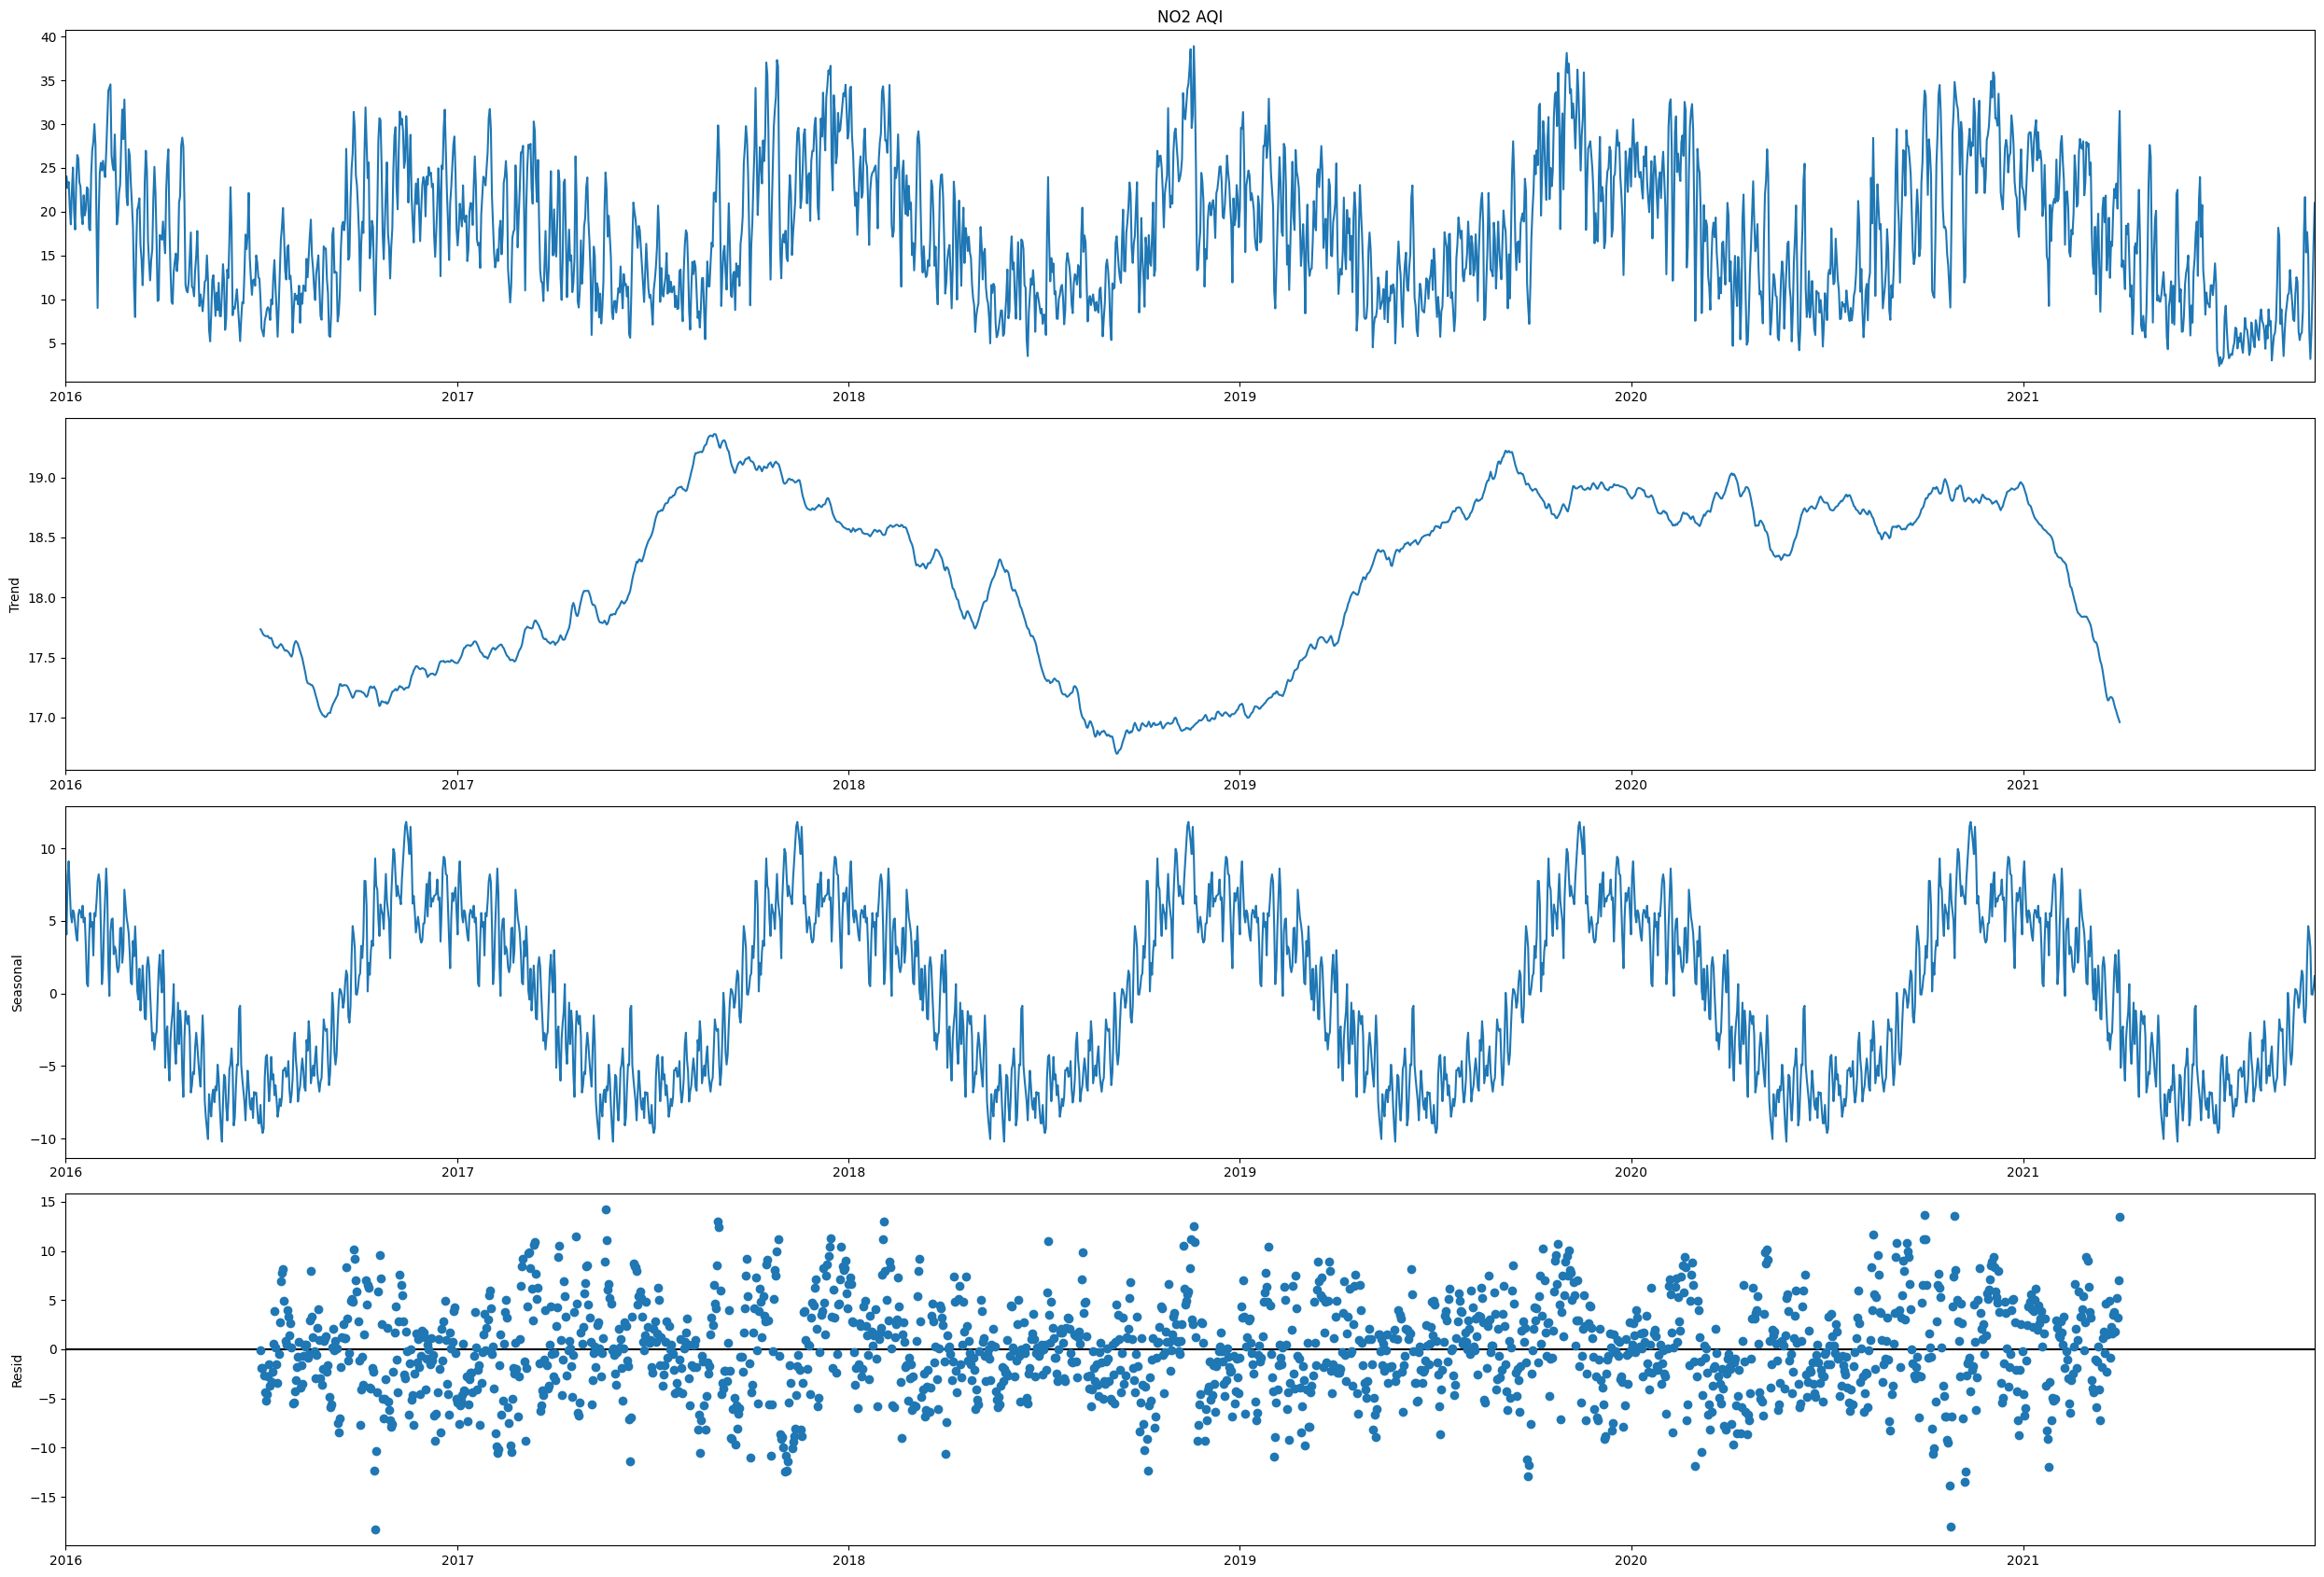

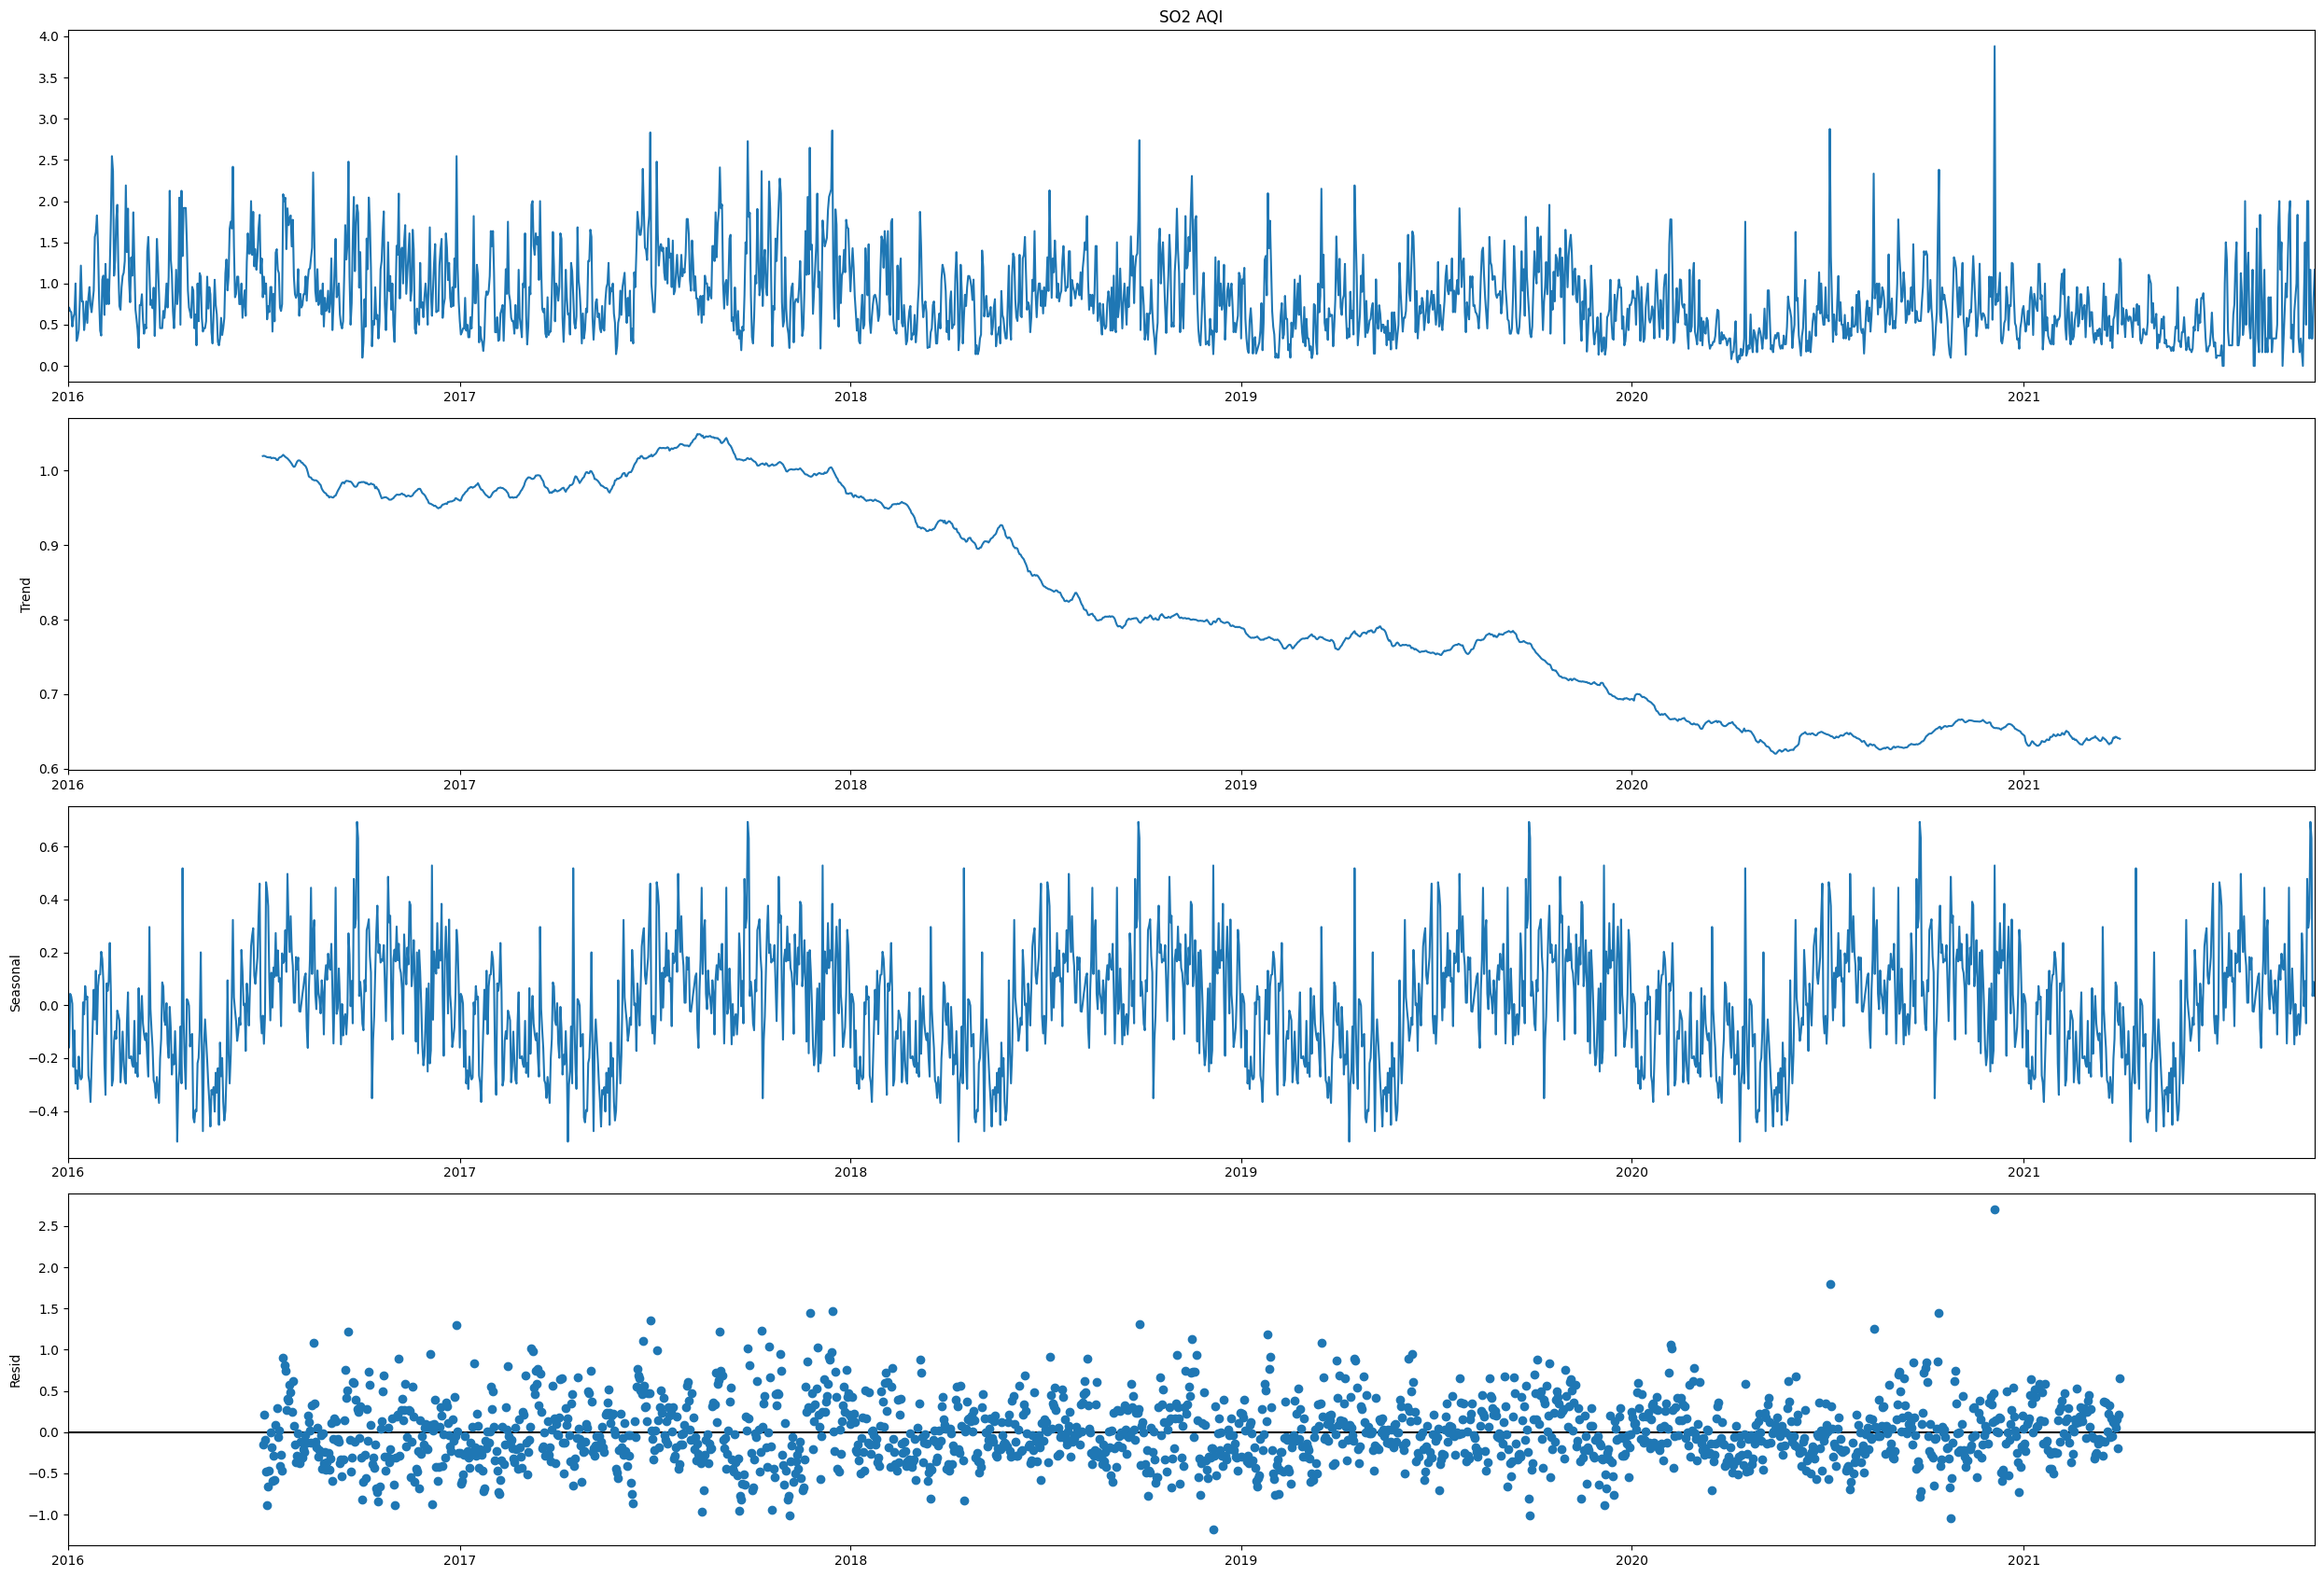

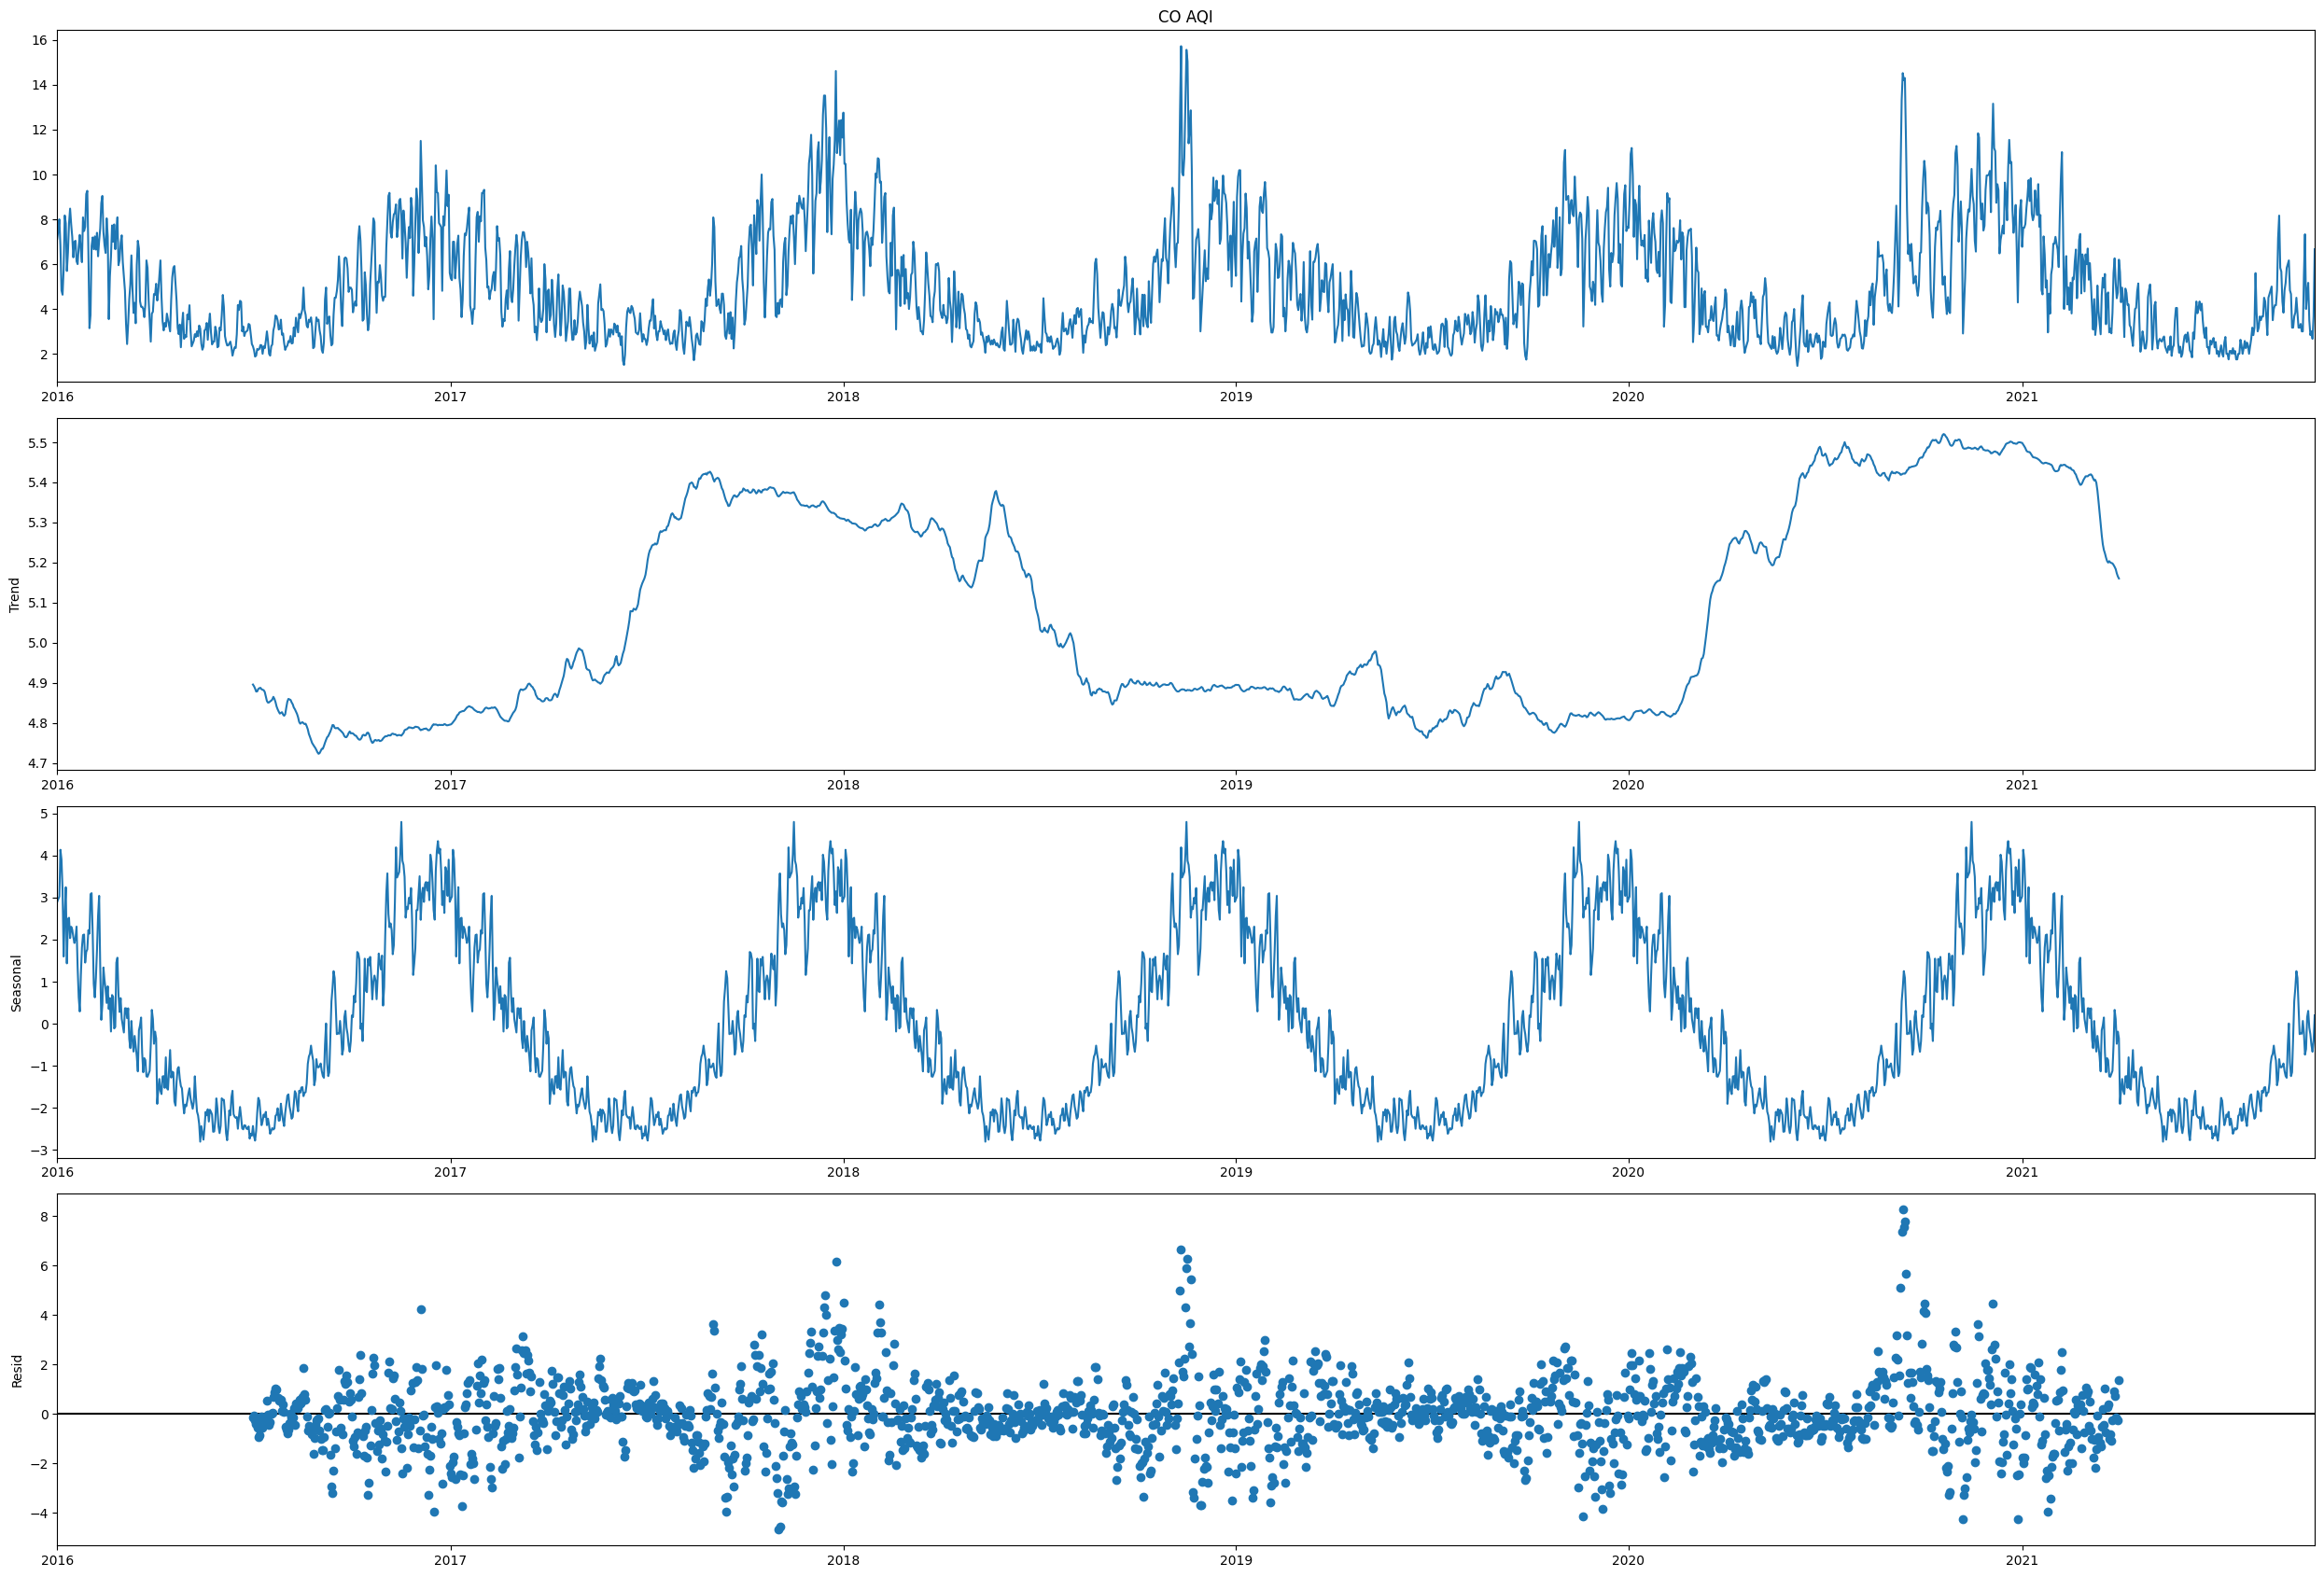

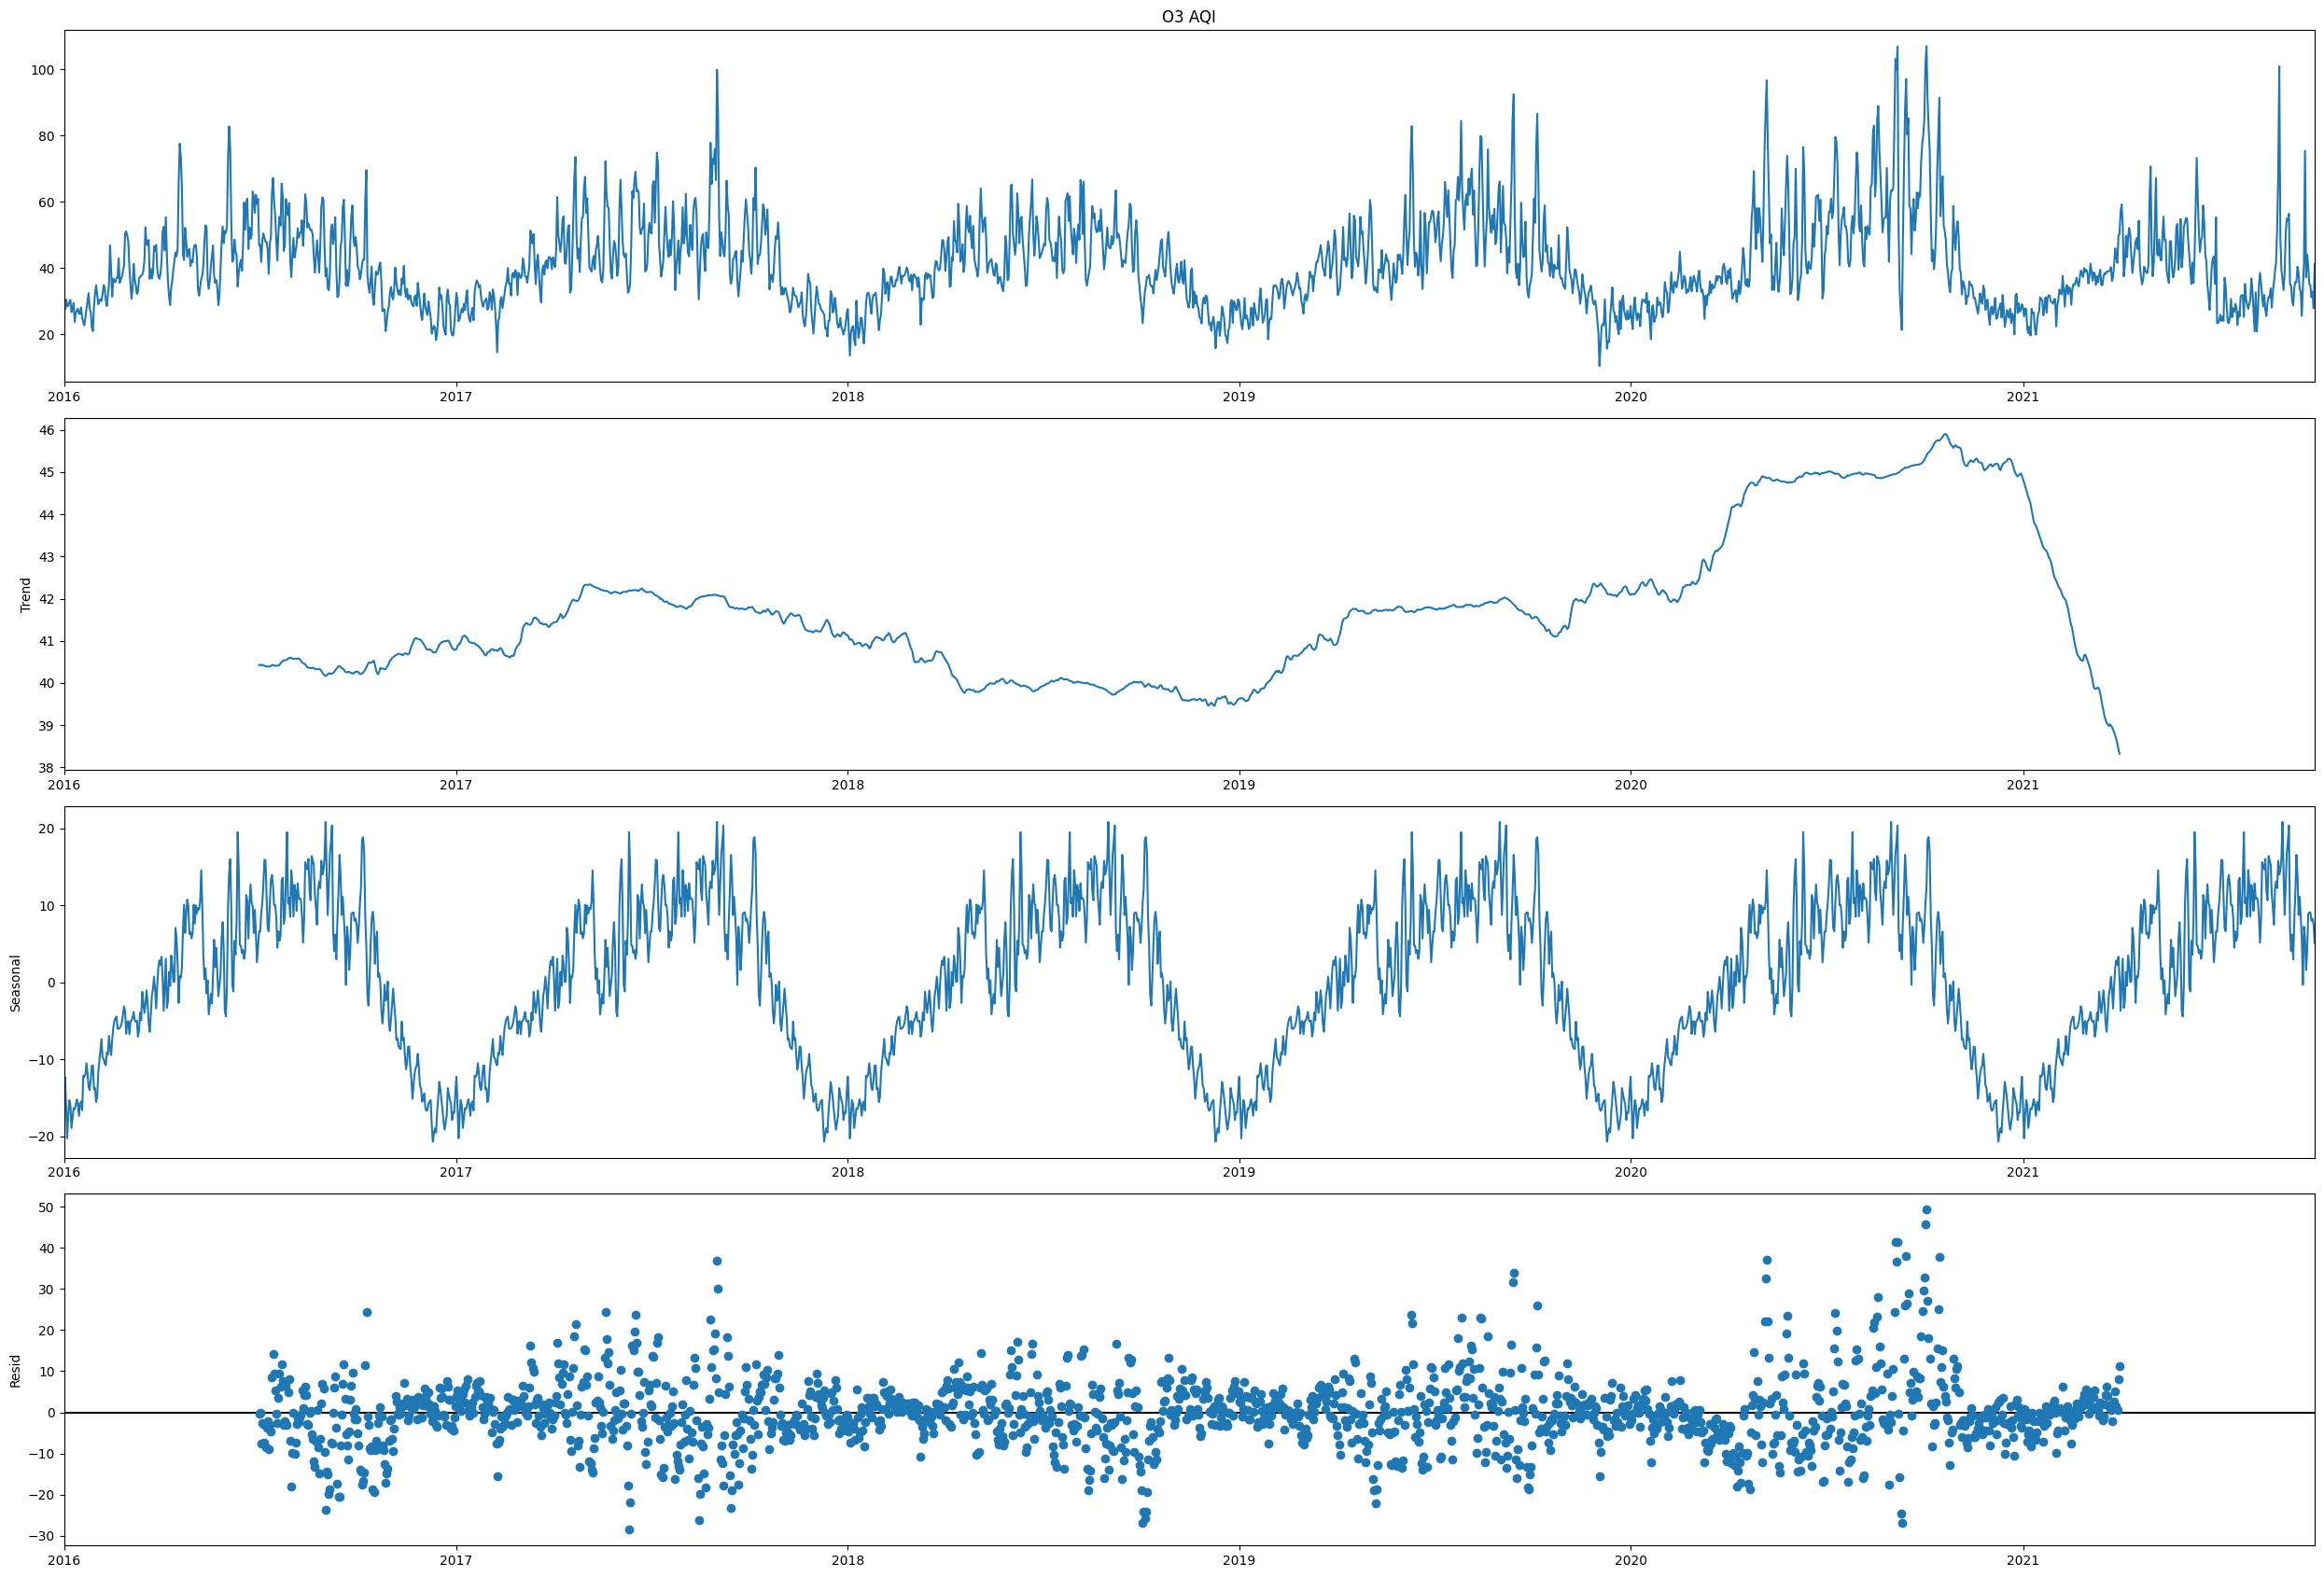

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(4):
  pollutantDecompose = seasonal_decompose(CaliforniaDataGroupedByDate[Pollutants[i]],model = 'additive',period = 365)
  pollutantDecompose.plot()

## Preprocessing and visualization of monthwise pollution index data.

In [ ]:
for i, col in enumerate(Pollutants):
  data = CaliforniaDataGroupedByDate

In [ ]:
CaliforniaDataGroupedYearMonth = CaliforniaData.groupby(['Year','State','Month'])['O3 AQI','SO2 AQI','NO2 AQI','CO AQI'].agg("max").reset_index()

<ipython-input-93-eb8d174a0125>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
CaliforniaDataGroupedYearMonth["Year_Month"] = CaliforniaDataGroupedYearMonth.apply(lambda x: '{}_{:02d}'.format(x['Year'],x["Month"]),axis = 1)

## Visualization of the monthly air pollutant values

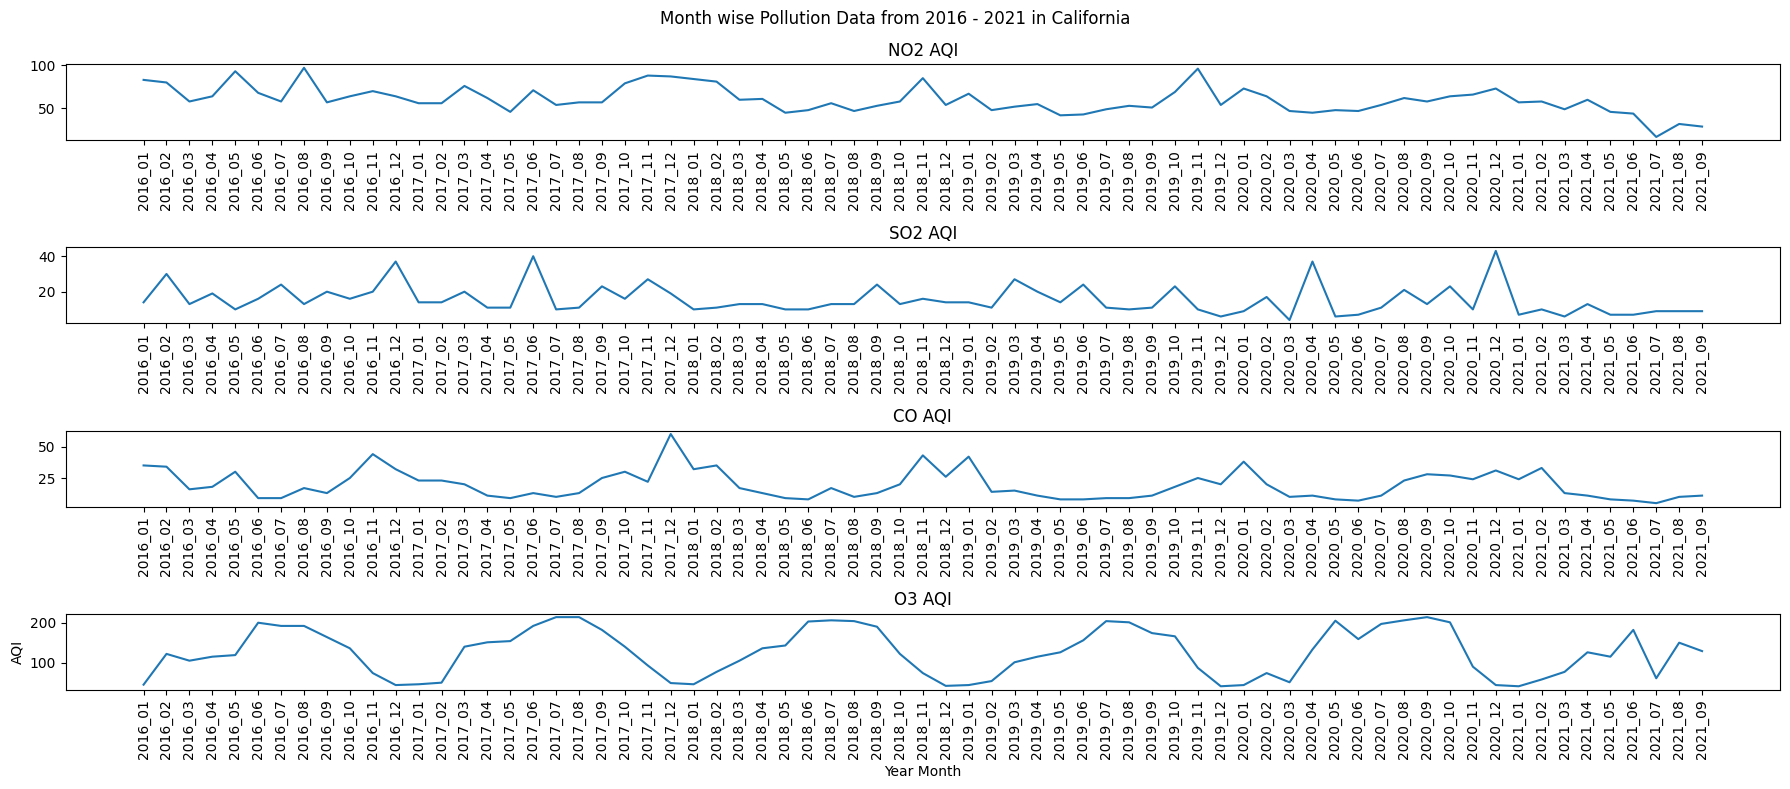

In [ ]:
fig, axs = plt.subplots(nrows=len(Pollutants), ncols=1, figsize=(18, 8))

# Iterate over the columns and plot each one
for i, col in enumerate(Pollutants):
    # Filter the dataframe by column and select the Year_Month and column values
    data = CaliforniaDataGroupedYearMonth[['Year_Month', col]]
    # Plot the data on the appropriate subplot
    axs[i].plot(data['Year_Month'], data[col])
    # Set the subplot title to the column name
    axs[i].set_title(col)
    axs[i].tick_params(axis = 'x',rotation = 90)

# Set the overall plot title
fig.suptitle('Month wise Pollution Data from 2016 - 2021 in California')

# Set the x and y axis labels for the last subplot
axs[-1].set_xlabel('Year Month')
axs[-1].set_ylabel('AQI')

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

## Visualizing the top 5 polluters in California by AQI value

<ipython-input-96-1f2253c6e640>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Text(0.1, 0.5, 'Mean value of AQI')

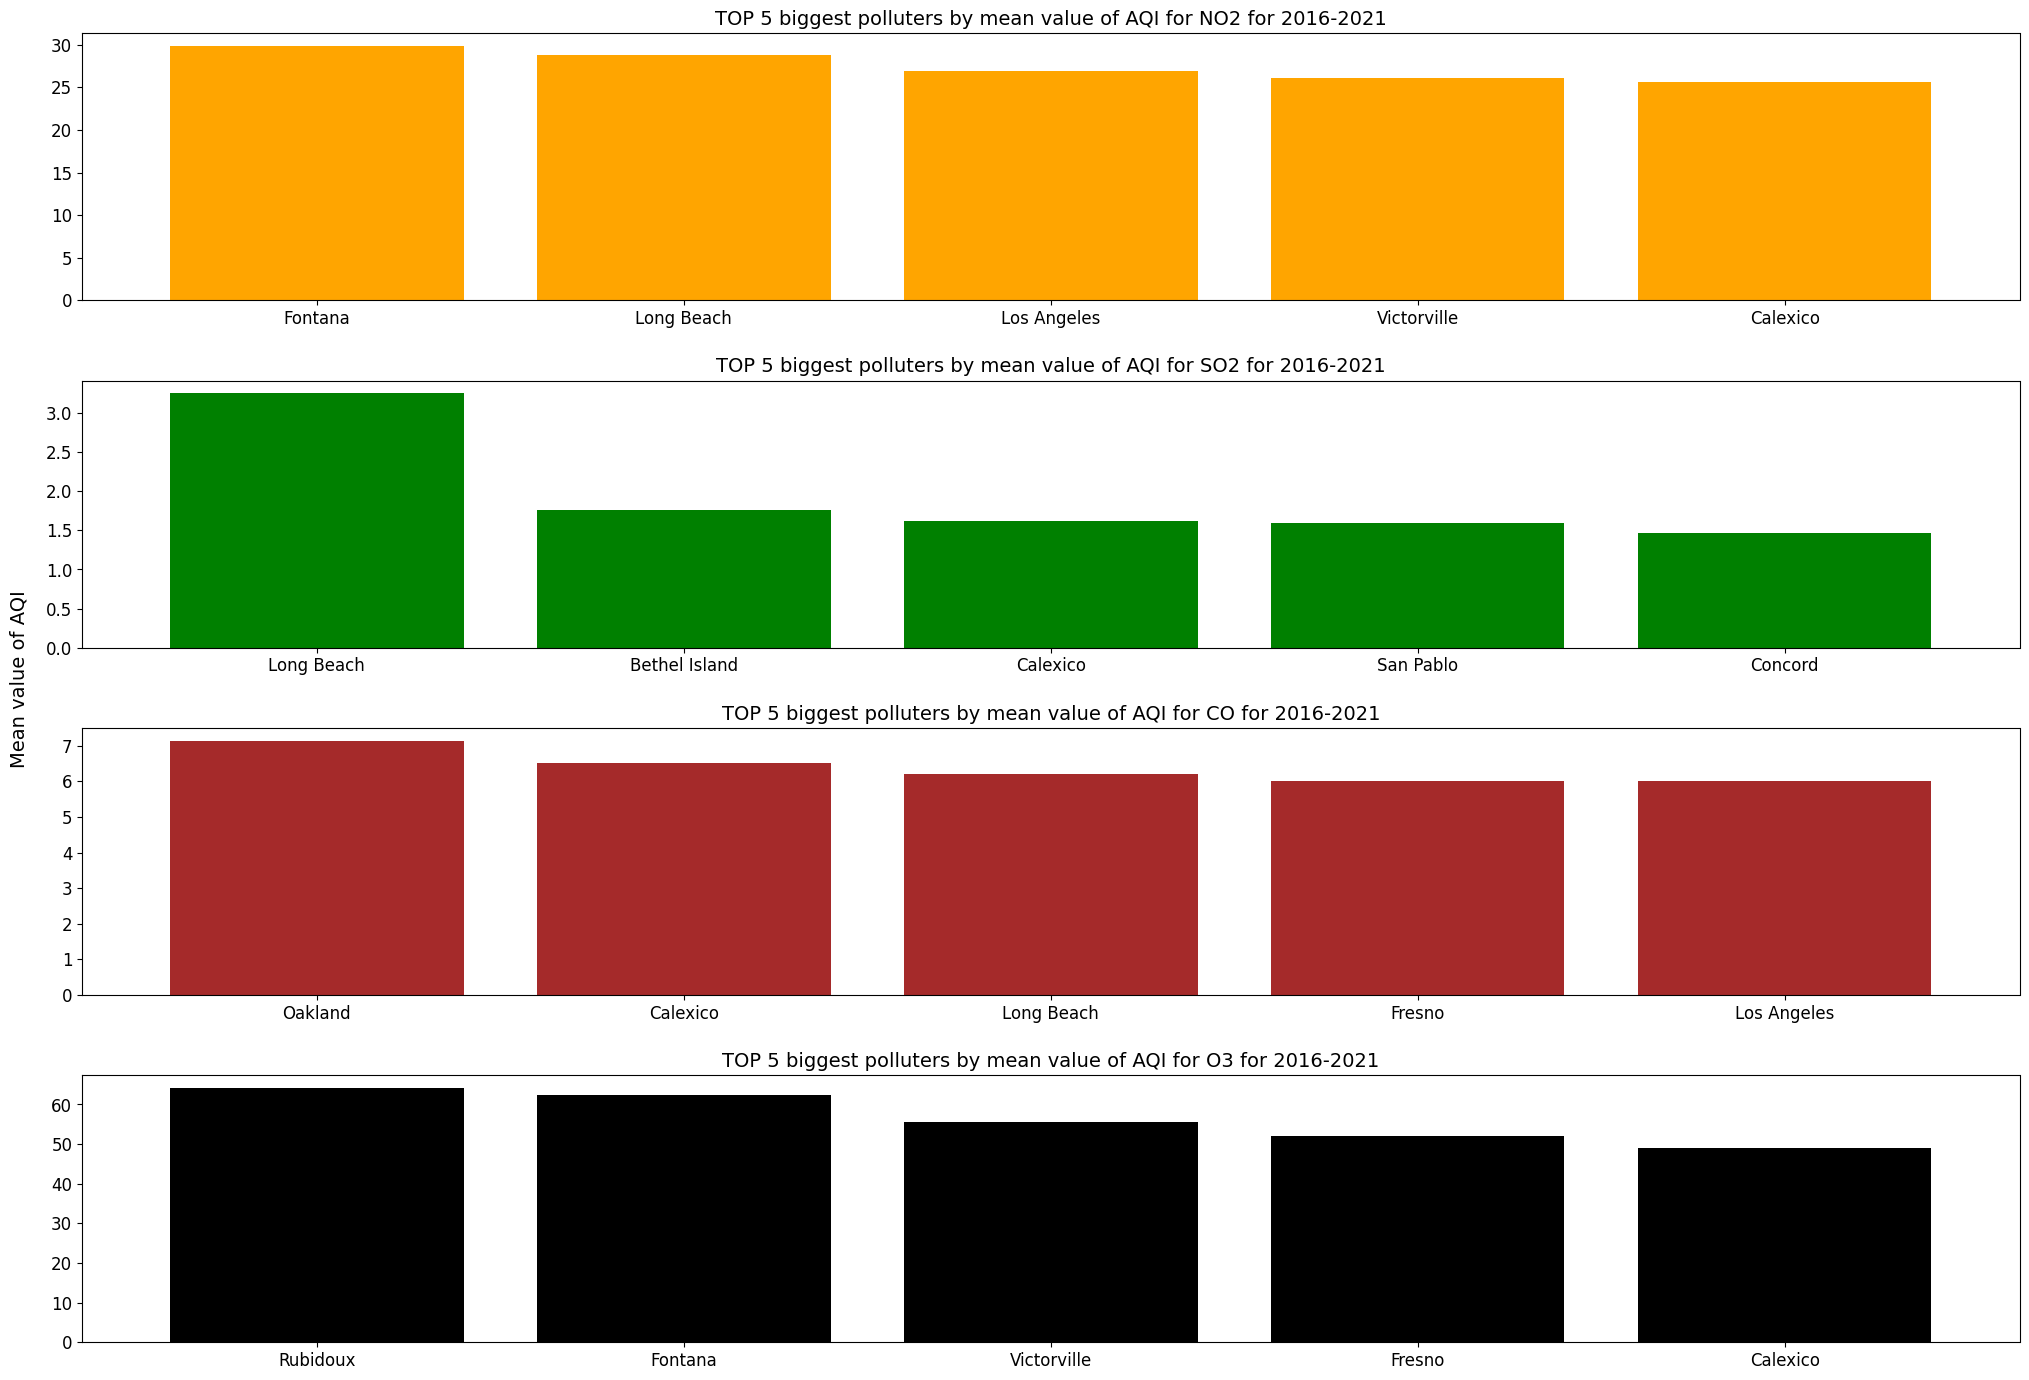

In [ ]:
CaliforniaDataAQICityWise = CaliforniaData[['City', 'Date', 'NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']]
PollutantName = ["NO2","SO2","CO","O3"]
Color = ["Orange","Green","Brown","Black"]
CaliforniaDataAQICityWiseGrouped = CaliforniaDataAQICityWise.groupby('City').mean().reset_index()

# Creating x variable for 5 biggest polluters
x = np.arange(5)

plt.rcParams["figure.figsize"] = (25, 17) 
# Adding four charts
fig, axs = plt.subplots(4, 1)

i= 0
while i < 4: 
  CaliforniaDataAQICityWiseGrouped.sort_values(by = Pollutants[i], ascending = False, inplace = True)
  barplot = axs[i].bar(x,Pollutants[i], data=CaliforniaDataAQICityWiseGrouped[:5], label = PollutantName[i], color = Color[i])
  xlabels = CaliforniaDataAQICityWiseGrouped.iloc[:5]['City']
  plt.sca(axs[i])
  plt.xticks(x, xlabels) # x axis marks
  axs[i].tick_params(axis='both', which='major', labelsize=12)
  axs[i].set_title('TOP 5 biggest polluters by mean value of AQI for ' + PollutantName[i]+ ' for 2016-2021', fontsize = 14) 
  i = i+1
# Space between charts
plt.subplots_adjust(hspace=0.3) 
fig.text(0.1, 0.5, 'Mean value of AQI', ha='center', va='center', rotation='vertical', fontsize = 14)

## Splitting data into training and test sets.

In [ ]:
CaliforniaDataGroupedByDate.index = pd.to_datetime(CaliforniaDataGroupedByDate.index)
CaliforniaDataGroupedByDate = CaliforniaDataGroupedByDate.sort_index(ascending = True)
train_data = CaliforniaDataGroupedByDate[:'2020-08-05']
test_data = CaliforniaDataGroupedByDate['2020-08-05':]

## Performing Average method of forecasting and visualizing the forecasted trends

In [ ]:
# Create a subplot with dropdown menu
fig = sp.make_subplots(rows=1, cols=1)
fig.update_layout(title="Pollutant Data")
MAEAverageValues = []
RMSEAverageValues = []

# Create a list to store dropdown buttons
dropdown_buttons = []

# Loop through each pollutant
for pollutant in Pollutants:
    average_value = train_data[pollutant].mean()  # Calculate the average of historical values
    average_forecast = np.full(len(test_data), average_value)  # Use the average as forecast for future values
    mae = mean_absolute_error(test_data[pollutant], average_forecast)
    MAEAverageValues.append(mae)
    rmse = np.sqrt(mean_squared_error(test_data[pollutant], average_forecast))
    RMSEAverageValues.append(rmse)
    print('\n', pollutant)
    print('Mean Absolute Error (MAE):', mae)
    print('Root Mean Squared Error (RMSE):', rmse)


 NO2 AQI
Mean Absolute Error (MAE): 7.515692489069792
Root Mean Squared Error (RMSE): 8.648620491208964

 SO2 AQI
Mean Absolute Error (MAE): 0.3841639615082907
Root Mean Squared Error (RMSE): 0.4736567348804677

 CO AQI
Mean Absolute Error (MAE): 2.119879775700131
Root Mean Squared Error (RMSE): 2.680136673536589

 O3 AQI
Mean Absolute Error (MAE): 12.136415102102083
Root Mean Squared Error (RMSE): 16.388321880939923


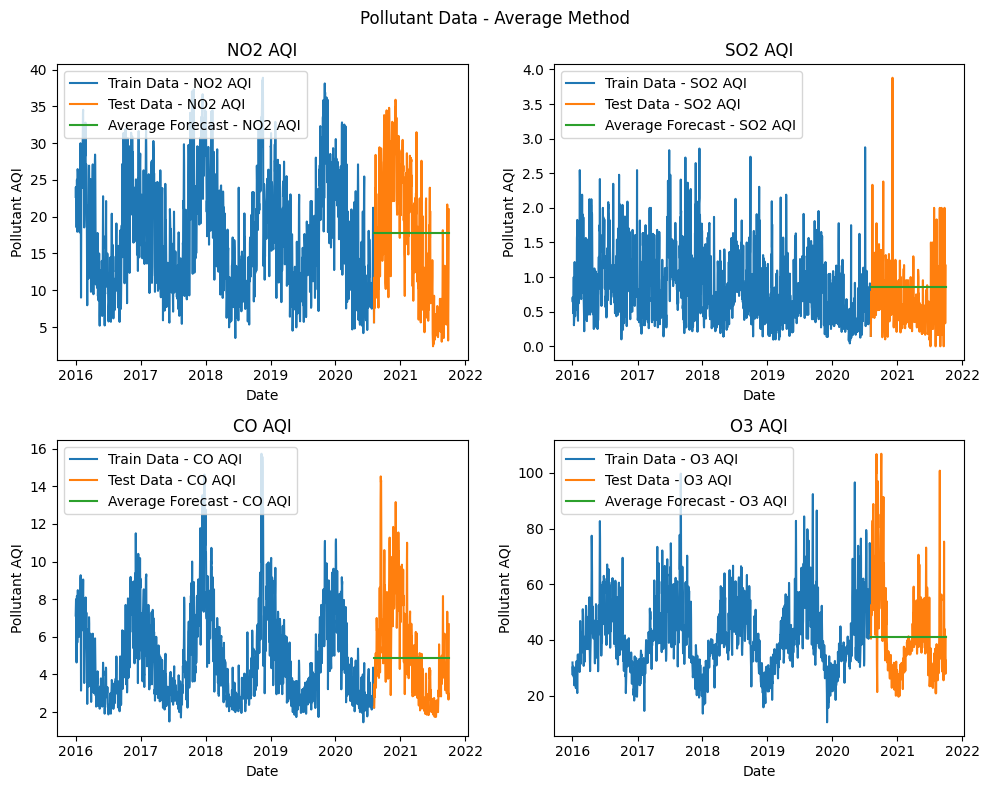

In [ ]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot data on each subplot
axs[0, 0].plot(train_data.index, train_data[Pollutants[0]], label='Train Data - {}'.format(Pollutants[0]))
axs[0, 0].plot(test_data.index, test_data[Pollutants[0]], label='Test Data - {}'.format(Pollutants[0]))
axs[0, 0].plot(test_data.index, np.full(len(test_data), train_data[Pollutants[0]].mean()), label='Average Forecast - {}'.format(Pollutants[0]))
axs[0, 0].set_title(Pollutants[0])
axs[0, 0].legend()

axs[0, 1].plot(train_data.index, train_data[Pollutants[1]], label='Train Data - {}'.format(Pollutants[1]))
axs[0, 1].plot(test_data.index, test_data[Pollutants[1]], label='Test Data - {}'.format(Pollutants[1]))
axs[0, 1].plot(test_data.index, np.full(len(test_data), train_data[Pollutants[1]].mean()), label='Average Forecast - {}'.format(Pollutants[1]))
axs[0, 1].set_title(Pollutants[1])
axs[0, 1].legend()

axs[1, 0].plot(train_data.index, train_data[Pollutants[2]], label='Train Data - {}'.format(Pollutants[2]))
axs[1, 0].plot(test_data.index, test_data[Pollutants[2]], label='Test Data - {}'.format(Pollutants[2]))
axs[1, 0].plot(test_data.index, np.full(len(test_data), train_data[Pollutants[2]].mean()), label='Average Forecast - {}'.format(Pollutants[2]))
axs[1, 0].set_title(Pollutants[2])
axs[1, 0].legend()

axs[1, 1].plot(train_data.index, train_data[Pollutants[3]], label='Train Data - {}'.format(Pollutants[3]))
axs[1, 1].plot(test_data.index, test_data[Pollutants[3]], label='Test Data - {}'.format(Pollutants[3]))
axs[1, 1].plot(test_data.index, np.full(len(test_data), train_data[Pollutants[3]].mean()), label='Average Forecast - {}'.format(Pollutants[3]))
axs[1, 1].set_title(Pollutants[3])
axs[1, 1].legend()

# Set common x and y labels
for ax in axs.flat:
    ax.set_xlabel('Date')
    ax.set_ylabel('Pollutant AQI')

# Add a title for the entire subplot
fig.suptitle('Pollutant Data - Average Method')

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


## Performing forecast using Moving Average Method.

The output is the average of all the training data values.


 NO2 AQI
Mean Absolute Error (MAE): 9.26708729832529
Root Mean Squared Error (RMSE): 10.873275547210783

 SO2 AQI
Mean Absolute Error (MAE): 0.2992455377268125
Root Mean Squared Error (RMSE): 0.43578679153887995

 CO AQI
Mean Absolute Error (MAE): 3.393542228287612
Root Mean Squared Error (RMSE): 3.7333642813043038

 O3 AQI
Mean Absolute Error (MAE): 10.270636381686055
Root Mean Squared Error (RMSE): 13.913164081055871


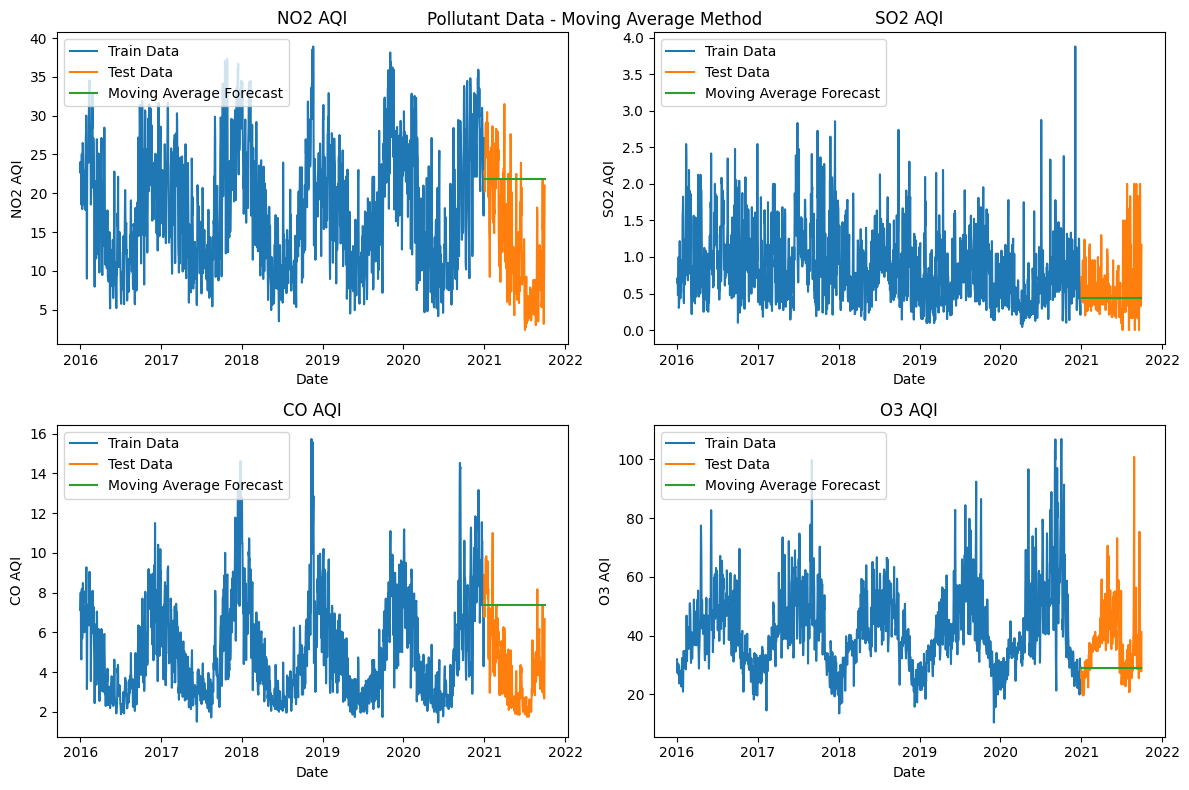

In [ ]:
train_data = CaliforniaDataGroupedByDate[:'2020-12-31']
test_data = CaliforniaDataGroupedByDate['2020-12-31':]
MAEMovingAverage = []
RMSEMovingAverage = []


# Create a (2,2) subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()  # Flatten the subplot grid for easier indexing

# Define window size for moving average
window_size = 7  # You can adjust this value to your desired window size

# Loop through each pollutant and plot in a subplot
for i, pollutant in enumerate(Pollutants):
    # Calculate the rolling mean of historical values
    rolling_mean = train_data[pollutant].rolling(window=window_size).mean()
    
    # Use the rolling mean as forecast for future values
    rolling_mean_forecast = rolling_mean[-1] * np.ones(len(test_data))  # Use the last rolling mean as forecast for test data
    
    mae = mean_absolute_error(test_data[pollutant], rolling_mean_forecast)
    rmse = np.sqrt(mean_squared_error(test_data[pollutant], rolling_mean_forecast))
    MAEMovingAverage.append(mae)
    RMSEMovingAverage.append(rmse)
    print('\n', pollutant)
    print('Mean Absolute Error (MAE):', mae)
    print('Root Mean Squared Error (RMSE):', rmse)
    axs[i].plot(train_data.index, train_data[pollutant], label='Train Data')
    axs[i].plot(test_data.index, test_data[pollutant], label='Test Data')
    axs[i].plot(test_data.index, rolling_mean_forecast, label='Moving Average Forecast')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(pollutant)
    axs[i].set_title(pollutant)
    axs[i].legend()

plt.tight_layout()
plt.suptitle('Pollutant Data - Moving Average Method')
plt.show()

## Forecasting using Naive Forecast

Here we simulate the previous days pollution values as the current days forecast. y(t+1) = y(t) 


 CO AQI
Mean Absolute Error (MAE) of CO AQI=  0.7443938672348641
Root Mean Squared Error (RMSE) of CO AQI=  1.0267286592542022

 NO2 AQI
Mean Absolute Error (MAE) of NO2 AQI=  2.9107257846623846
Root Mean Squared Error (RMSE) of NO2 AQI=  3.837391947922587

 SO2 AQI
Mean Absolute Error (MAE) of SO2 AQI=  0.2976491190576379
Root Mean Squared Error (RMSE) of SO2 AQI=  0.4497624536649998

 O3 AQI
Mean Absolute Error (MAE) of O3 AQI=  4.959317332883924
Root Mean Squared Error (RMSE) of O3 AQI=  7.942701557600234


<ipython-input-101-937a49f3eefa>:38: UserWarning:

The figure layout has changed to tight



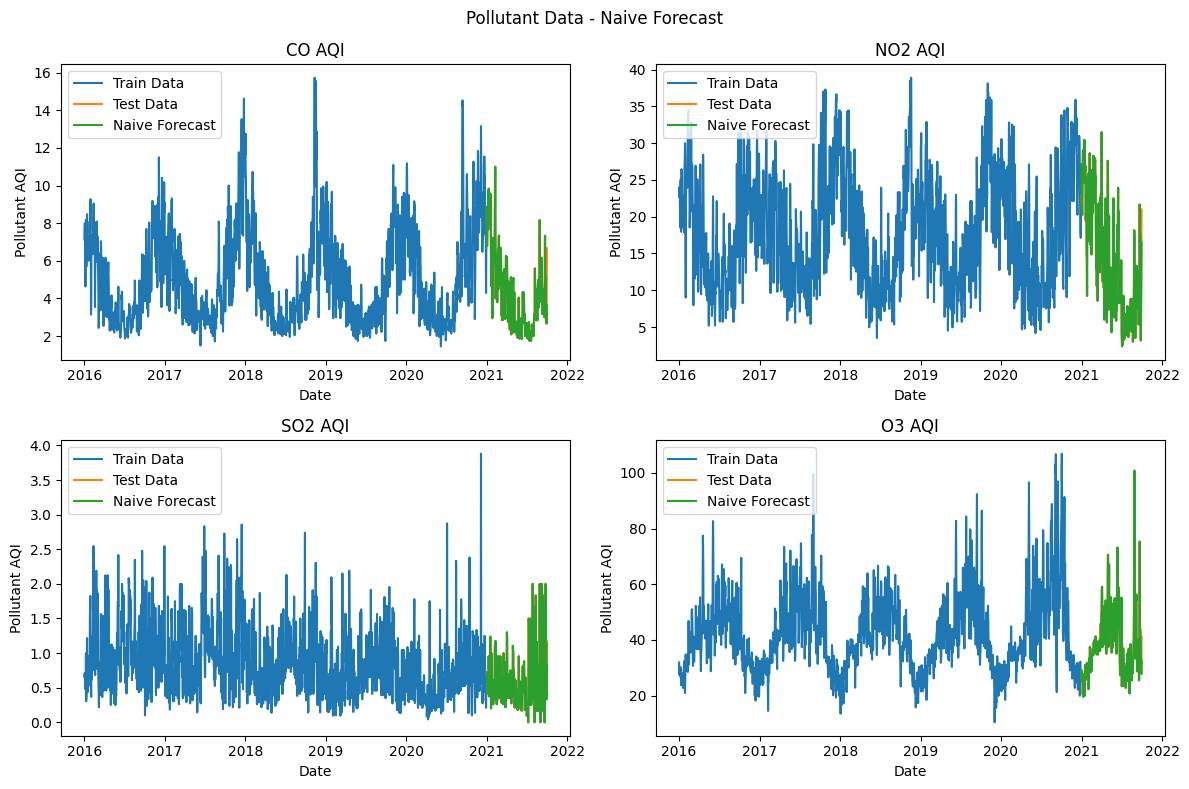

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
MAENaiveMethod = []
RMSENaiveMethod = []
pollutants = ['CO AQI', 'NO2 AQI', 'SO2 AQI', 'O3 AQI']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
fig.suptitle('Pollutant Data - Naive Forecast')

# Loop through each pollutant
for i, pollutant in enumerate(pollutants):
    train_data_naive = CaliforniaDataGroupedByDate[:'2020-12-31'][pollutant]
    test_data_naive = CaliforniaDataGroupedByDate['2020-12-31':][pollutant]
    naive_forecast = CaliforniaDataGroupedByDate['2020-12-30':"2021-09-29"][pollutant]
    mae = mean_absolute_error(test_data_naive, naive_forecast)
    rmse = np.sqrt(mean_squared_error(test_data_naive, naive_forecast))
    RMSENaiveMethod.append(rmse)
    MAENaiveMethod.append(mae)
    print('\n', pollutant)
    print('Mean Absolute Error (MAE) of '+pollutant+'= ', mae)
    print('Root Mean Squared Error (RMSE) of '+pollutant+'= ', rmse)

    # Plot train data
    axs[i//2, i%2].plot(train_data_naive.index, train_data_naive, label='Train Data')
    # Plot test data
    axs[i//2, i%2].plot(test_data_naive.index, test_data_naive, label='Test Data')
    # Plot naive forecast
    axs[i//2, i%2].plot(test_data_naive.index, naive_forecast, label='Naive Forecast')
    axs[i//2, i%2].set_title(pollutant)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Pollutant AQI')
    axs[i//2, i%2].legend()

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()


## Forecast using Seasonal Naive method

This method assumes the value of the pollutant in the same time but in the previous year/selected season.


 CO AQI
Mean Absolute Error (MAE): 1.4894231311390391
Root Mean Squared Error (RMSE): 2.193677400734736

 NO2 AQI
Mean Absolute Error (MAE): 6.540909386441229
Root Mean Squared Error (RMSE): 8.193564198488412

 SO2 AQI
Mean Absolute Error (MAE): 0.405212499289096
Root Mean Squared Error (RMSE): 0.5361235355805322

 O3 AQI
Mean Absolute Error (MAE): 15.740094360476347
Root Mean Squared Error (RMSE): 21.26082335030781


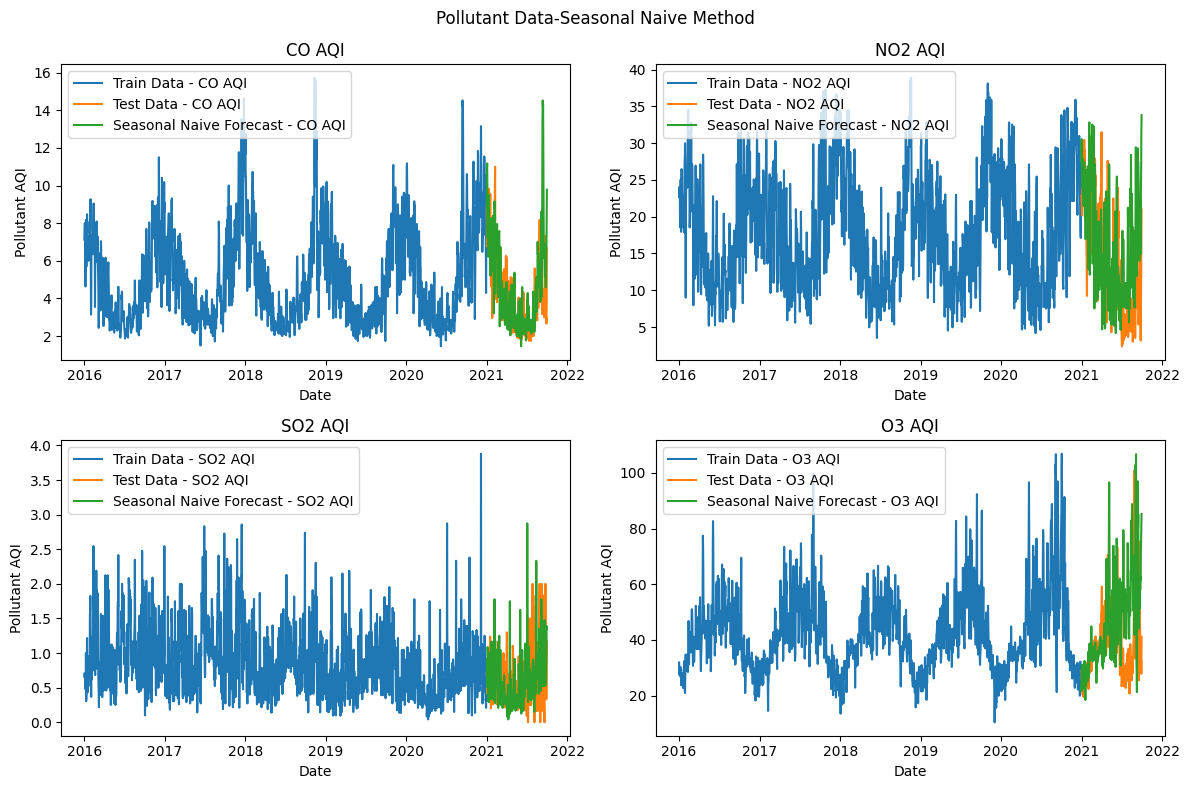

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
MAESeasonalNaive = []
RMSESeasonalNaive = []
pollutants = ['CO AQI', 'NO2 AQI', 'SO2 AQI', 'O3 AQI']

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Pollutant Data-Seasonal Naive Method")

# Loop through each pollutant and create a subplot for each
for i, pollutant in enumerate(pollutants):
    row = i // 2
    col = i % 2
    
    seasonal_values = train_data.iloc[-365:][pollutant]
    seasonal_values = pd.Series(np.tile(seasonal_values, int(np.ceil(len(test_data)/365))))
    seasonal_naive_forecast = seasonal_values[:len(test_data)]
    mae = mean_absolute_error(test_data[pollutant], seasonal_naive_forecast)
    rmse = np.sqrt(mean_squared_error(test_data[pollutant], seasonal_naive_forecast))
    RMSESeasonalNaive.append(rmse)
    MAESeasonalNaive.append(mae)
    print('\n',pollutant)
    print('Mean Absolute Error (MAE):', mae)
    print('Root Mean Squared Error (RMSE):', rmse)
    
    # Plot train data
    axs[row, col].plot(train_data.index, train_data[pollutant], label='Train Data - {}'.format(pollutant))
    # Plot test data
    axs[row, col].plot(test_data.index, test_data[pollutant], label='Test Data - {}'.format(pollutant))
    # Plot seasonal naive forecast
    axs[row, col].plot(test_data.index, seasonal_naive_forecast, label='Seasonal Naive Forecast - {}'.format(pollutant))
    
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Pollutant AQI')
    axs[row, col].set_title(pollutant)
    axs[row, col].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
i = 0
SarimaxMAE = []
SarimaxRMSE = []
predictions = pd.DataFrame([])
CompleteTrainData = pd.DataFrame([])
CompleteTestData = pd.DataFrame([])
fig = make_subplots(rows=2, cols=2, subplot_titles=['NO2', 'SO2', 'CO', 'O3'])
df = CaliforniaDataGroupedByDate
while i < 4:
  df_monthly = df[[Pollutants[i]]].resample('D').mean()


  train_data = df_monthly['2016':'2021']
  CompleteTrainData[Pollutants[i]] = train_data
  test_data = df_monthly['2021':]
  CompleteTestData[Pollutants[i]] = test_data

  model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
  results = model.fit()

  prediction= results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
  predictions[Pollutants[i]] = prediction
  from sklearn.metrics import mean_absolute_error, mean_squared_error

  mae = mean_absolute_error(test_data, prediction)
  rmse = np.sqrt(mean_squared_error(test_data, prediction))
  SarimaxMAE.append(mae)
  SarimaxRMSE.append(rmse)
  
  print('MAE for :' + str(Pollutants[i]), mae)
  print('RMSE for :' + str(Pollutants[i]),rmse)
  i = i+1


MAE for :NO2 AQI 2.942433719925405
RMSE for :NO2 AQI 3.850038488507827
MAE for :SO2 AQI 0.27389380779822925
RMSE for :SO2 AQI 0.3808128416394308
MAE for :CO AQI 0.713542428285052
RMSE for :CO AQI 0.969190689587114
MAE for :O3 AQI 4.794957597760919
RMSE for :O3 AQI 7.333924019478281


In [ ]:
#To be run before the next step
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Forecasting using SARIMAX model. 

The order and seasonal order are found using the auto_arima funciton from the pdarima library. The predictions for each pollutant are found using these parameters.

In [ ]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from plotly.subplots import make_subplots

# Define the pollutants and their corresponding column names
Pollutants = ['NO2 AQI', 'SO2 AQI', 'CO AQI', 'O3 AQI']

# Create empty lists to store metrics
SarimaxMAE = []
SarimaxRMSE = []

# Create empty DataFrames to store train and test data
CompleteTrainData = pd.DataFrame([])
CompleteTestData = pd.DataFrame([])

# Create an empty DataFrame to store predictions
predictions = pd.DataFrame([])

# Create a subplot for each pollutant
fig = make_subplots(rows=2, cols=2, subplot_titles=Pollutants)

# Load the CaliforniaDataGroupedByDate
df = CaliforniaDataGroupedByDate

# Iterate over each pollutant
for i in range(len(Pollutants)):
    # Resample data to monthly frequency
    df_monthly = df[[Pollutants[i]]].resample('D').mean()

    # Split data into train and test
    train_data = df_monthly['2016':'2021']
    CompleteTrainData[Pollutants[i]] = train_data
    test_data = df_monthly['2021':]
    CompleteTestData[Pollutants[i]] = test_data

    # Automatically select optimal SARIMA model orders using auto_arima
    model = auto_arima(train_data, seasonal=True, suppress_warnings=True)
    order = model.order
    seasonal_order = model.seasonal_order
    # Fit SARIMAX model with optimal orders
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Make predictions
    prediction = results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
    predictions[Pollutants[i]] = prediction

    # Calculate and store MAE and RMSE
    mae = mean_absolute_error(test_data, prediction)
    rmse = np.sqrt(mean_squared_error(test_data, prediction))
    SarimaxMAE.append(mae)
    SarimaxRMSE.append(rmse)

    # Add actual and predicted values to the subplot

    print('MAE for ' + str(Pollutants[i]) + ':', mae)
    print('RMSE for ' + str(Pollutants[i]) + ':', rmse)



(3, 0, 2)


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



MAE for NO2 AQI: 2.844762684164569
RMSE for NO2 AQI: 3.735837397950624
(1, 1, 1)
MAE for SO2 AQI: 0.2710774911443004
RMSE for SO2 AQI: 0.37762030478593195
(2, 0, 2)


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



MAE for CO AQI: 0.719921536592082
RMSE for CO AQI: 0.9723198161813902
(5, 0, 1)
MAE for O3 AQI: 4.76747196868648
RMSE for O3 AQI: 7.463101004712876


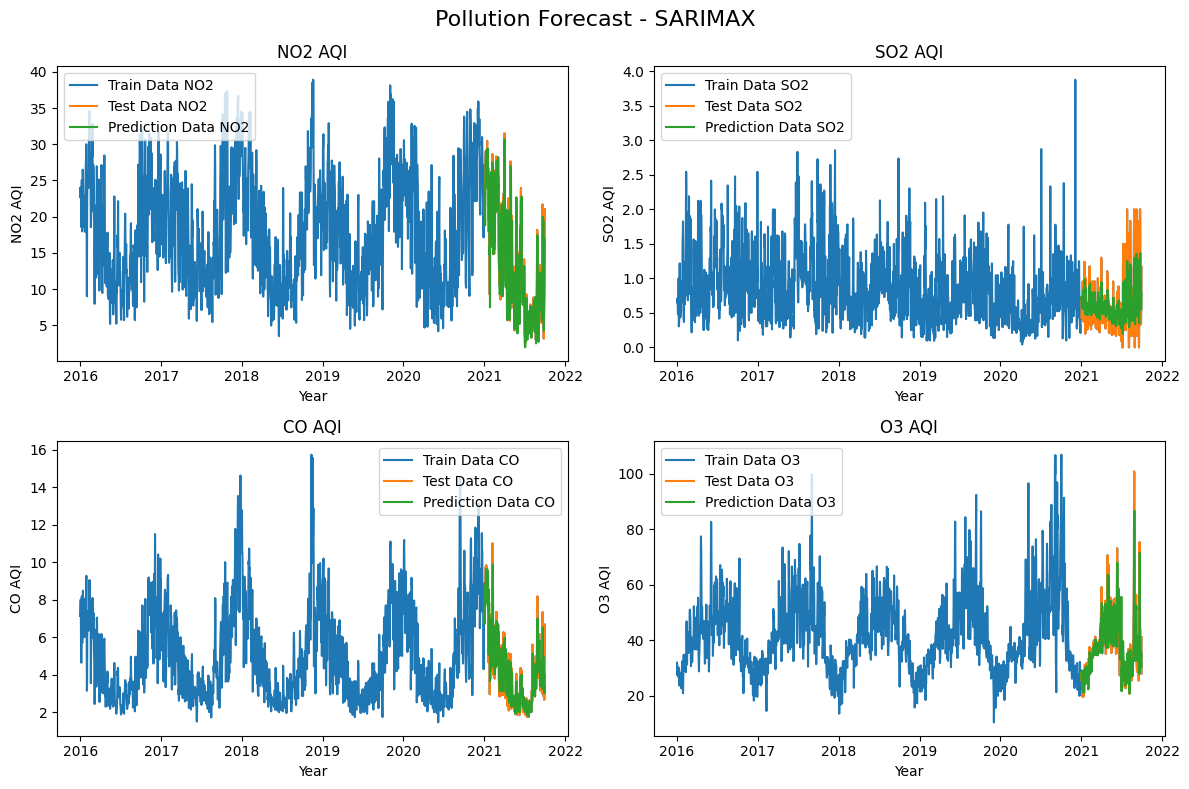

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot for NO2 AQI
axs[0, 0].plot(CompleteTrainData.index, CompleteTrainData[Pollutants[0]], label='Train Data NO2')
axs[0, 0].plot(CompleteTestData.index, CompleteTestData[Pollutants[0]], label='Test Data NO2')
axs[0, 0].plot(predictions.index, predictions[Pollutants[0]], label='Prediction Data NO2')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('NO2 AQI')
axs[0, 0].set_title('NO2 AQI')
axs[0, 0].legend()

# Plot for SO2 AQI
axs[0, 1].plot(CompleteTrainData.index, CompleteTrainData[Pollutants[1]], label='Train Data SO2')
axs[0, 1].plot(CompleteTestData.index, CompleteTestData[Pollutants[1]], label='Test Data SO2')
axs[0, 1].plot(predictions.index, predictions[Pollutants[1]], label='Prediction Data SO2')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('SO2 AQI')
axs[0, 1].set_title('SO2 AQI')
axs[0, 1].legend()

# Plot for CO AQI
axs[1, 0].plot(CompleteTrainData.index, CompleteTrainData[Pollutants[2]], label='Train Data CO')
axs[1, 0].plot(CompleteTestData.index, CompleteTestData[Pollutants[2]], label='Test Data CO')
axs[1, 0].plot(predictions.index, predictions[Pollutants[2]], label='Prediction Data CO')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('CO AQI')
axs[1, 0].set_title('CO AQI')
axs[1, 0].legend()

# Plot for O3 AQI
axs[1, 1].plot(CompleteTrainData.index, CompleteTrainData[Pollutants[3]], label='Train Data O3')
axs[1, 1].plot(CompleteTestData.index, CompleteTestData[Pollutants[3]], label='Test Data O3')
axs[1, 1].plot(predictions.index, predictions[Pollutants[3]], label='Prediction Data O3')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('O3 AQI')
axs[1, 1].set_title('O3 AQI')
axs[1, 1].legend()

# Set overall title for the plot
fig.suptitle('Pollution Forecast - SARIMAX', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Forecasting Pollutant values using LSTM Model

The pollution data is considered as a sequential data(with time) and days as a feature. The number of steps, the layers of the neural network architecture are defined and the predictions are made.


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the features to use
features = ['NO2 AQI', 'SO2 AQI', 'CO AQI', 'O3 AQI']



# Scale the data
scaler = MinMaxScaler()
data = scaler.fit_transform(CaliforniaDataGroupedByDate[features])

# Split the data into training and test sets
train_data = data[:-270]
test_data = data[-270:]

# Define the number of time steps to use in the input sequences
n_steps = 21

# Create the training data
X_train = []
y_train = []
for i in range(n_steps, len(train_data)):
    X_train.append(train_data[i-n_steps:i])
    y_train.append(train_data[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(features)))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Create the test data
X_test = []
y_test = []
for i in range(n_steps, len(test_data)):
    X_test.append(test_data[i-n_steps:i])
    y_test.append(test_data[i])
X_test, y_test = np.array(X_test), np.array(y_test)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Invert the scaling of the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MAE:', mae)
print('RMSE:', rmse)

Epoch 1/50
57/57 [==============================] - 6s 26ms/step - loss: 0.0281
Epoch 2/50
57/57 [==============================] - 2s 28ms/step - loss: 0.0130
Epoch 3/50
57/57 [==============================] - 1s 25ms/step - loss: 0.0123
Epoch 4/50
57/57 [==============================] - 2s 27ms/step - loss: 0.0117
Epoch 5/50
57/57 [==============================] - 2s 27ms/step - loss: 0.0109
Epoch 6/50
57/57 [==============================] - 1s 23ms/step - loss: 0.0105
Epoch 7/50
57/57 [==============================] - 2s 39ms/step - loss: 0.0100
Epoch 8/50
57/57 [==============================] - 2s 36ms/step - loss: 0.0096
Epoch 9/50
57/57 [==============================] - 2s 33ms/step - loss: 0.0089
Epoch 10/50
57/57 [==============================] - 1s 22ms/step - loss: 0.0089
Epoch 11/50
57/57 [==============================] - 2s 27ms/step - loss: 0.0084
Epoch 12/50
57/57 [==============================] - 1s 25ms/step - loss: 0.0082
Epoch 13/50
57/57 [==================

In [ ]:
LstmMAE = []
LstmRMSE = []
for i in range(4):
  mae = mean_absolute_error(y_test[i], y_pred[i])
  rmse = np.sqrt(mean_squared_error(y_test[i], y_pred[i]))
  LstmMAE.append(mae)
  LstmRMSE.append(rmse)
  print('MAE:', mae)
  print('RMSE:', rmse)

MAE: 4.180057650262659
RMSE: 5.231142562556199
MAE: 3.6980858946388415
RMSE: 4.953447843106494
MAE: 2.9207225990922816
RMSE: 4.204061318895416
MAE: 2.084547779776834
RMSE: 2.5877913805860913


## Visualizing the predictions for each pollutant

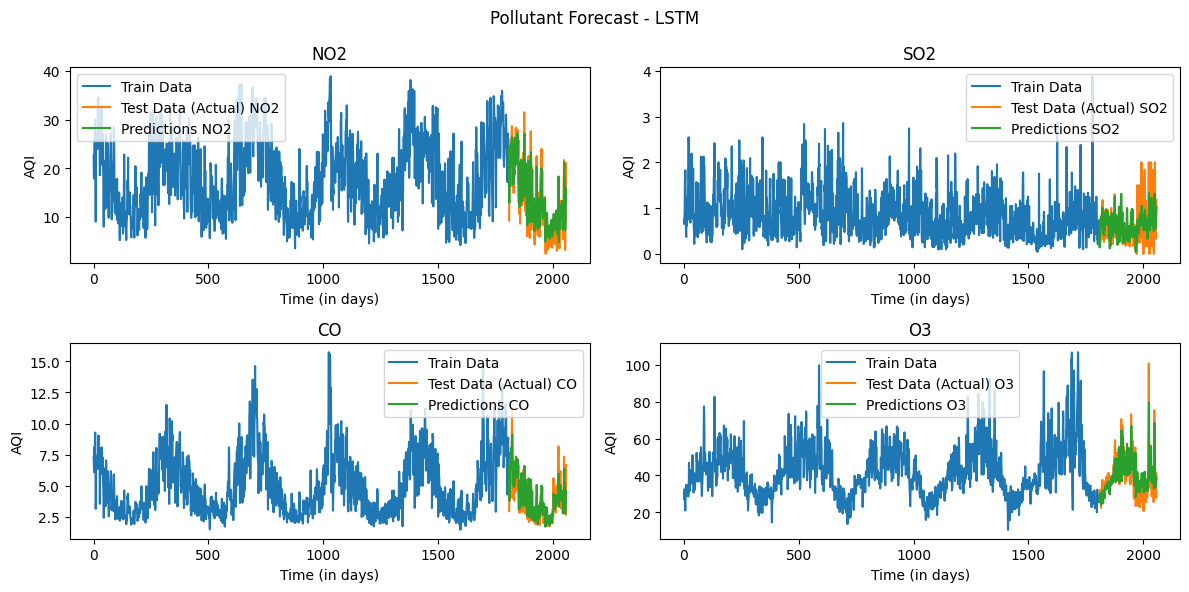

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle('Pollutant Forecast - LSTM')

axs[0, 0].plot(range(len(y_train)), y_train[:, 0], label='Train Data')
axs[0, 0].plot(range(len(y_train), len(y_train) + len(y_test)), y_test[:, 0], label='Test Data (Actual) NO2')
axs[0, 0].plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred[:, 0], label='Predictions NO2')
axs[0, 0].set_title('NO2')
axs[0, 0].set_xlabel('Time (in days)')
axs[0, 0].set_ylabel('AQI')
axs[0, 0].legend()

axs[0, 1].plot(range(len(y_train)), y_train[:, 1], label='Train Data')
axs[0, 1].plot(range(len(y_train), len(y_train) + len(y_test)), y_test[:, 1], label='Test Data (Actual) SO2')
axs[0, 1].plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred[:, 1], label='Predictions SO2')
axs[0, 1].set_title('SO2')
axs[0, 1].set_xlabel('Time (in days)')
axs[0, 1].set_ylabel('AQI')
axs[0, 1].legend()

axs[1, 0].plot(range(len(y_train)), y_train[:, 2], label='Train Data')
axs[1, 0].plot(range(len(y_train), len(y_train) + len(y_test)), y_test[:, 2], label='Test Data (Actual) CO')
axs[1, 0].plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred[:, 2], label='Predictions CO')
axs[1, 0].set_title('CO')
axs[1, 0].set_xlabel('Time (in days)')
axs[1, 0].set_ylabel('AQI')
axs[1, 0].legend()

axs[1, 1].plot(range(len(y_train)), y_train[:, 3], label='Train Data')
axs[1, 1].plot(range(len(y_train), len(y_train) + len(y_test)), y_test[:, 3], label='Test Data (Actual) O3')
axs[1, 1].plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred[:, 3], label='Predictions O3')
axs[1, 1].set_title('O3')
axs[1, 1].set_xlabel('Time (in days)')
axs[1, 1].set_ylabel('AQI')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


## Forecasting the output for the next 30 days

In [ ]:
# Get the last n_steps number of observations from the test_data
start_point = test_data[-n_steps:]

# Create an empty list to hold the forecasted values
forecast = []

# Number of days to forecast
n_forecast = 30

# Loop through each day to forecast
for i in range(n_forecast):
    # Reshape the starting point to match the model input shape
    X = start_point.reshape((1, n_steps, len(features)))
    
    # Use the model to predict the AQI values for the next day
    y_pred = model.predict(X)
    
    # Append the predicted values to the forecasted values list
    forecast.append(y_pred[0])
    
    # Update the starting point with the predicted values for the next day
    start_point = np.concatenate([start_point[1:], y_pred], axis=0)

# Invert the scaling of the forecasted values
forecast = scaler.inverse_transform(forecast)



1/1 [==============================] - 0s 26ms/step


## Visualization of the forecast for the next 30 days for each pollutant

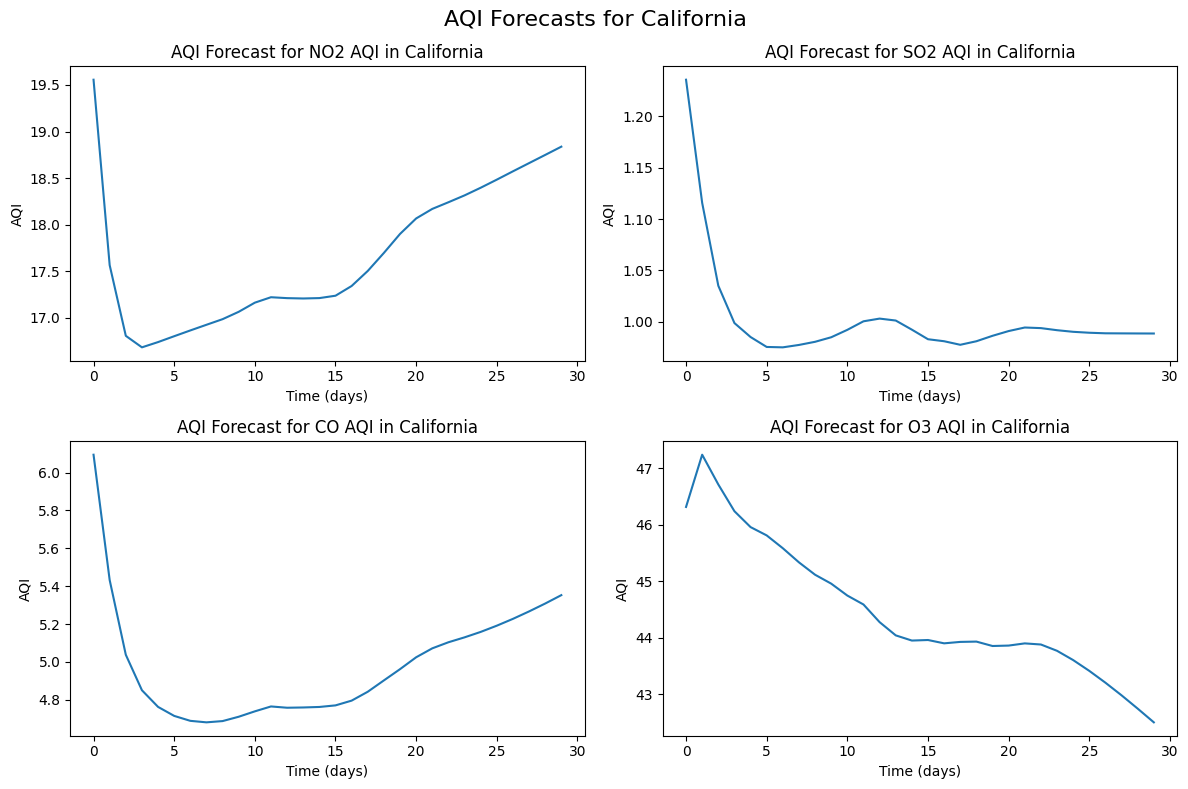

In [ ]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Loop over the four features and plot the forecast for each feature in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.plot(forecast[:, i])
    ax.set_title('AQI Forecast for ' + Pollutants[i] + ' in California')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('AQI')

# Add a title for the entire figure
fig.suptitle('AQI Forecasts for California', fontsize=16)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


# Model comparison and metrics evaluation

In [ ]:
MAEAverageValues.append('Average Method')
MAEMovingAverage.append('Moving Average Method')
MAENaiveMethod.append('Naive Method')
MAESeasonalNaive.append('Seasonal Naive Method')
SarimaxMAE.append('SARIMAX Method')
LstmMAE.append('LSTM Method')
RMSEAverageValues.append('Average Method')
RMSEMovingAverage.append('Moving Average Method')
RMSENaiveMethod.append('Naive Method')
RMSESeasonalNaive.append('Seasonal Naive Method')
SarimaxRMSE.append('SARIMAX Method')
LstmRMSE.append('LSTM Method')





In [ ]:
RMSEDataFrame = pd.DataFrame([], columns = ['NO2 AQI','SO2 AQI','CO AQI','O3 AQI','Time Series Method'])
MAEDataFrame = pd.DataFrame([],columns = ['NO2 AQI','SO2 AQI','CO AQI','O3 AQI','Time Series Method'])


In [ ]:
AllMAEValues = [MAEAverageValues,MAEMovingAverage,MAENaiveMethod,MAESeasonalNaive,SarimaxMAE,LstmMAE]
AllRMSEValues = [RMSEAverageValues,RMSEMovingAverage, RMSENaiveMethod,RMSESeasonalNaive,SarimaxRMSE, LstmRMSE]
for i in AllMAEValues:
  MAEDataFrame.loc[len(MAEDataFrame)] = i
for i in AllRMSEValues:
  RMSEDataFrame.loc[len(RMSEDataFrame)] = i

In [ ]:
RMSEDataFrame.index = RMSEDataFrame['Time Series Method']
RMSEDataFrame.drop('Time Series Method',axis = 1,inplace = True)
MAEDataFrame.index = MAEDataFrame['Time Series Method']
MAEDataFrame.drop('Time Series Method',axis = 1,inplace = True)

In [ ]:
RMSEDataFrame

NO2 AQI   SO2 AQI    CO AQI     O3 AQI
Time Series Method                                             
Average Method          8.648620  0.473657  2.680137  16.388322
Moving Average Method  10.873276  0.435787  3.733364  13.913164
Naive Method            1.026729  3.837392  0.449762   7.942702
Seasonal Naive Method   2.193677  8.193564  0.536124  21.260823
SARIMAX Method          3.735837  0.377620  0.972320   7.463101
LSTM Method             5.231143  4.953448  4.204061   2.587791

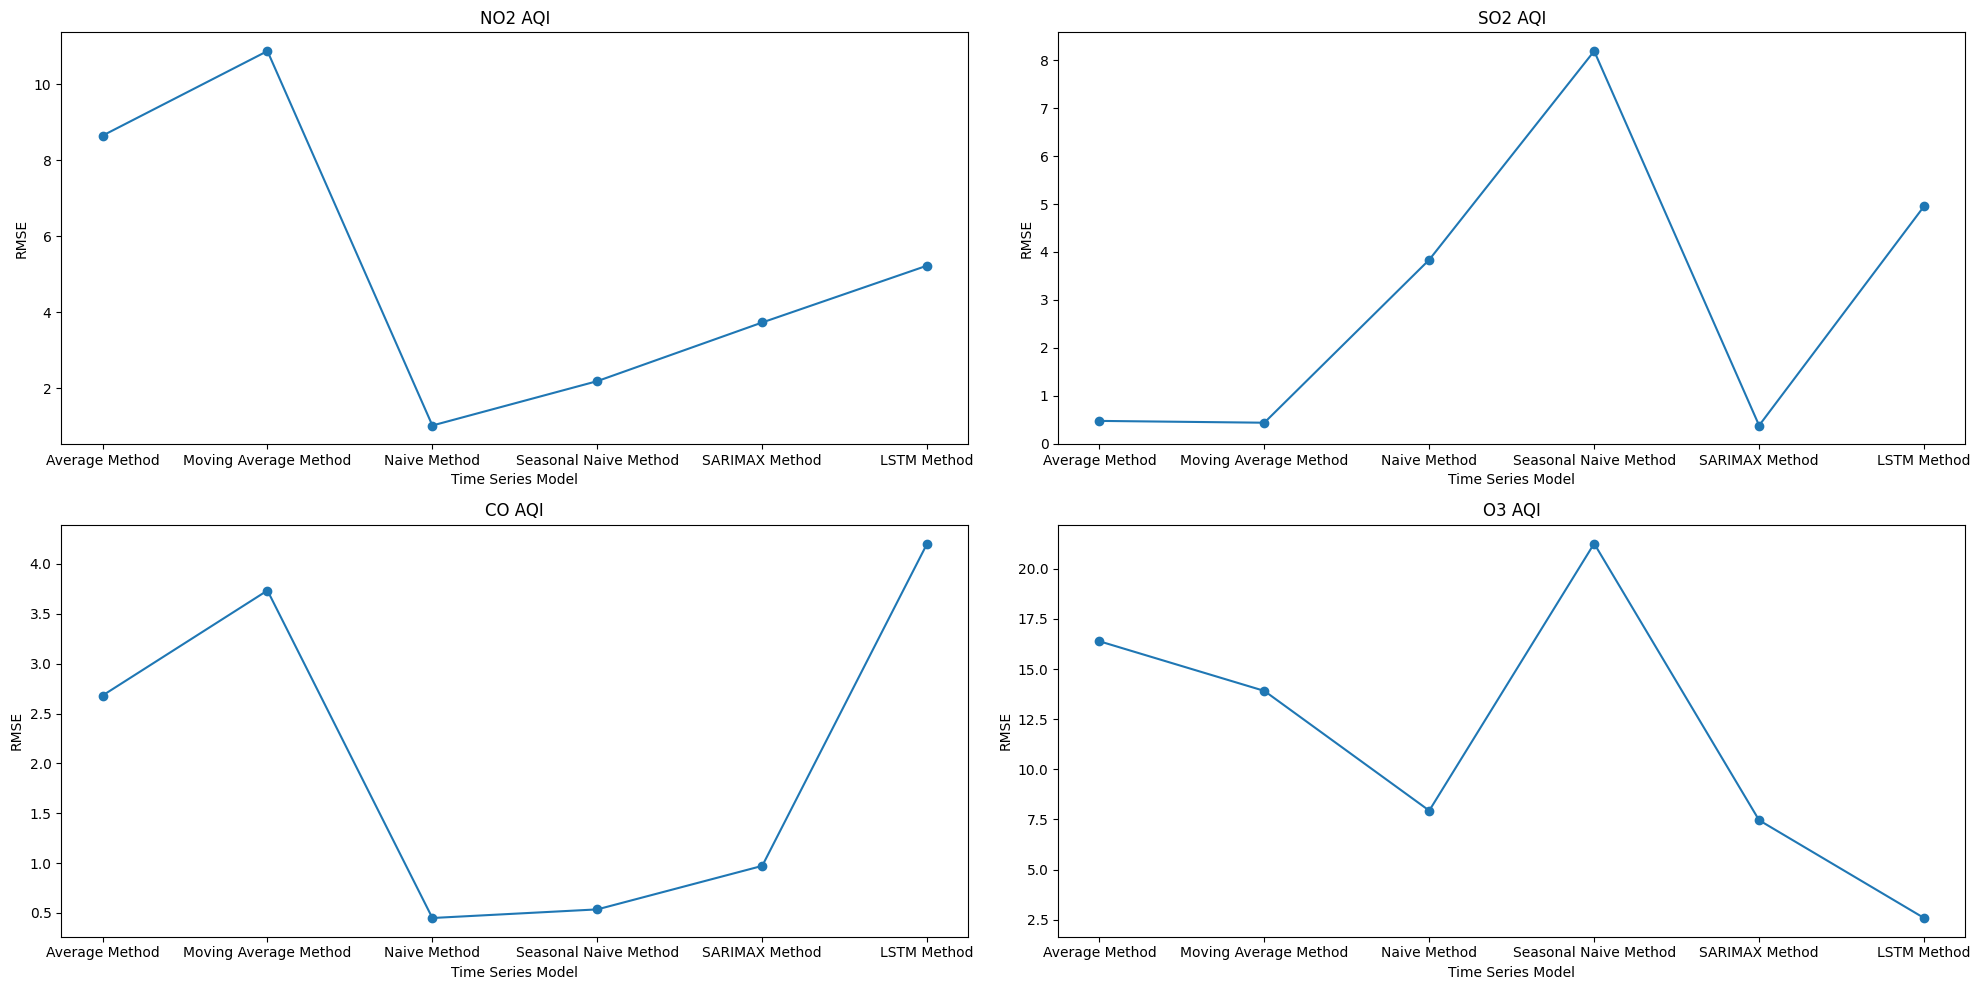

In [ ]:
#  Plot for RMSE

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten() 

# Plot the data for each pollutant using a for loop
for i, pollutant in enumerate(RMSEDataFrame.columns):

    axs[i].plot(RMSEDataFrame.index, RMSEDataFrame[pollutant], marker='o')
    axs[i].set_title(pollutant)
    axs[i].set_xlabel('Time Series Model')
    axs[i].set_ylabel('RMSE')


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

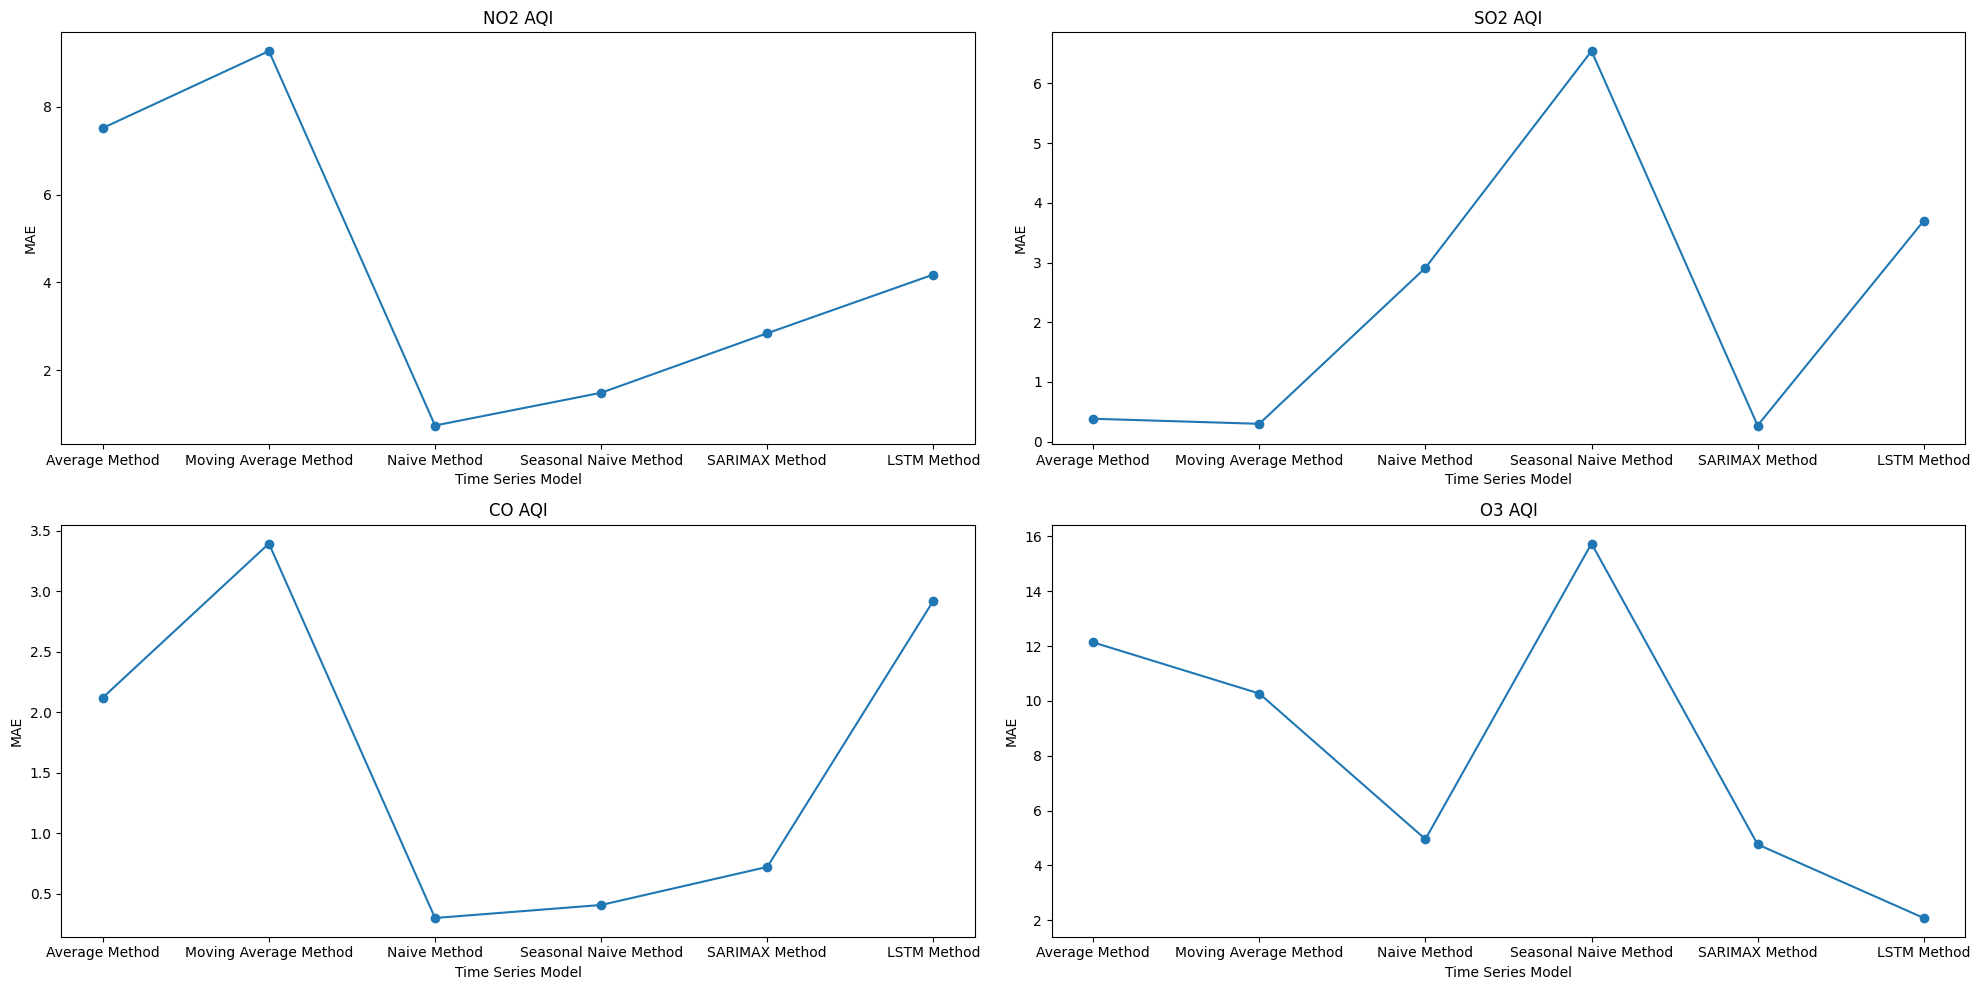

In [ ]:
# PLot for MAE

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten() 

# Plot the data for each pollutant using a for loop
for i, pollutant in enumerate(MAEDataFrame.columns):

    axs[i].plot(MAEDataFrame.index, MAEDataFrame[pollutant], marker='o')
    axs[i].set_title(pollutant)
    axs[i].set_xlabel('Time Series Model')
    axs[i].set_ylabel('MAE')


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()